Valinor Data Analysis Framework
================================

Public Template - TCP Homa workloads 0.4 mbps fixed rate- captured by Valinor-N
--------------------------

Extra information about the experiment goes here ...

----------------------------

## Plot/data configurations

Use below box to adjust the plot settings and names for each scenario.

In [1]:
import os
import sys
import random
import copy
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import poisson, norm
from hurst import compute_Hc, random_walk

from backend import *

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

font = {'family': 'sans-serif', 'size': 16}
font_label = {'family': 'sans-serif', 'size': 16}


plt.rc('font', **font)
plt.rc('legend', fontsize=16)


##### maps key to experiment name. modify as required ########
EXPERIMENT_MAP = {b'0': 'W1', b'1': 'W2', b'2': 'W3', b'3': 'W4', b'4': 'W5'}
#############################################################
colors = {}
legends = {b'0': 'W1', b'1': 'W2', b'2': 'W3', b'3': 'W4', b'4': 'W5'}
markers = {b'0': 'x', b'1':'s', b'2': '.', b'3': 'v', b'4': '<', b'5': '*', b'6': 'P', b'7': ''}
alphas = {b'0': 0.4, b'1':1, b'2': 0.4, b'3': 1, b'4': 0.4, b'5': 1, b'6': 0.4, b'7': 1}
linestyles = {b'0': 'solid', b'1':'dotted', b'2': 'dashed', b'3': 'dashdot', b'4': (0, (3, 1, 1, 1, 1, 1)), b'5': (0, (5, 10)), b'6': 'dotted', b'7': 'dashed'}

Data import
----------

This step loads the data from Redis and distributes timestamp data into several lists.

In [2]:
entries = connect_and_process_all_keys(exclude=[]) # b'1', b'3', b'4', b'5', b'6'
ts_data = get_ts_data_all_keys(entries)
ipg_data, ts_norm_data = get_ipg_data_all_keys(entries)
ts_sizes = get_ts_sizes_all_keys(entries)
queue_delta = get_queue_delta_all_keys(entries)
ts_aggregate_data = get_aggregate_ts_data_all_keys(entries)
ipg_agg_data, ts_aggregate_norm_data = get_aggregate_ipg_data_all_keys(entries)

print("Processed raw data into lists")

Connected to Redis
Found keys: [b'4', b'0', b'1', b'3', b'2']
Queried key b'4', total entries= 130245
Finished processing key b'4'
Queried key b'0', total entries= 1053873
Finished processing key b'0'
Queried key b'1', total entries= 511906
Finished processing key b'1'
Queried key b'3', total entries= 131067
Finished processing key b'3'
Queried key b'2', total entries= 205370
Finished processing key b'2'
Processed raw data into lists


General info
-----------

Number of flows and experiment duration extracted from timestamp data

In [4]:
experiment_durations = {}
for experiment, ts_data_list in ts_data.items():
    print("Experiment {} : {}".format(experiment, EXPERIMENT_MAP[experiment]))
    print("Total number of flows: ", format(len(ts_data_list), ','))
    if len(ts_aggregate_data[experiment]) < 2:
        print("Insufficient aggregate data")
    else:
        experiment_durations[experiment] = ts_aggregate_data[experiment][-1] - ts_aggregate_data[experiment][0]
        experiment_duration = experiment_durations[experiment]
        print("Experiment duration: {}s {}ms {}us {}ns".format(experiment_duration//1000000000, (experiment_duration//1000000)%1000, (experiment_duration//1000)%1000, (experiment_duration//1000000)%1000))
    print("---------------------------")

Experiment b'2' : W3
Total number of flows:  256
Experiment duration: 3s 933ms 985us 933ns
---------------------------
Experiment b'3' : W4
Total number of flows:  256
Experiment duration: 4s 8ms 691us 8ns
---------------------------
Experiment b'0' : W1
Total number of flows:  256
Experiment duration: 3s 869ms 331us 869ns
---------------------------
Experiment b'4' : W5
Total number of flows:  218
Experiment duration: 3s 994ms 55us 994ns
---------------------------
Experiment b'1' : W2
Total number of flows:  256
Experiment duration: 3s 905ms 762us 905ns
---------------------------


## Packet length CDF

Aggregate CDF of SK_BUFF lengths

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


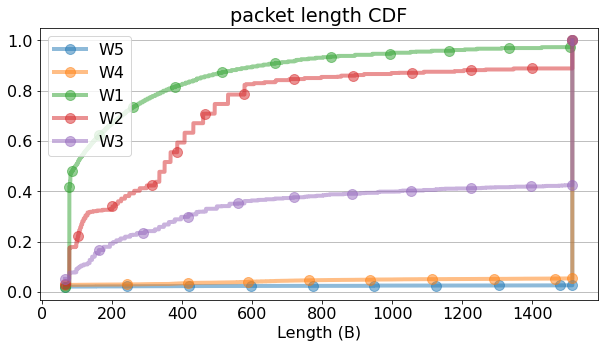

In [4]:
plots = []
agg_ts_size = {}
fig, ax1 = plt.subplots(figsize=(10,5))
for experiment, ts_sizes_flows in ts_sizes.items():
    agg_ts_size[experiment] = []
    for flow, flow_size_list in ts_sizes_flows.items():
        for i in flow_size_list:
            agg_ts_size[experiment].append(i)
    ecdf_f = ECDF(agg_ts_size[experiment])
    cdf_x = np.linspace(min(agg_ts_size[experiment]), max(agg_ts_size[experiment]), 400000)
    cdf_y = ecdf_f(cdf_x)
    plots.append(ax1.plot(cdf_x, cdf_y, marker='o', markevery=0.1, markersize=10, linewidth=4, alpha=0.5, label=EXPERIMENT_MAP[experiment]))
ax1.set_ylabel("")
ax1.set_xlabel("Length (B)")
ax1.set_title("packet length CDF")
ax1.grid(axis='y')
plt.legend()
plt.show()

## Queuing Delay CDF

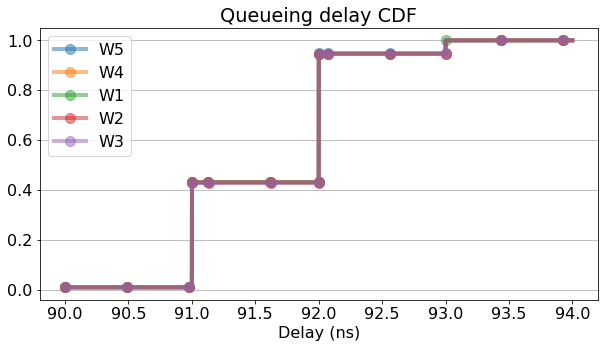

In [5]:
plots = []
agg_q = {}
fig, ax1 = plt.subplots(figsize=(10,5))
for experiment, ts_deltas_flows in queue_delta.items():
    agg_q[experiment] = []
    for flow, flow_que_list in ts_deltas_flows.items():
        for i in flow_que_list:
            agg_q[experiment].append(i)
    ecdf_f = ECDF(agg_q[experiment])
    cdf_x = np.linspace(min(agg_q[experiment]), max(agg_q[experiment]), 40000)
    cdf_y = ecdf_f(cdf_x)
    plots.append(ax1.plot(cdf_x, cdf_y, marker='o', markevery=0.1, markersize=10, linewidth=4, alpha=0.5, label=EXPERIMENT_MAP[experiment]))
ax1.set_ylabel("")
ax1.set_xlabel("Delay (ns)")
ax1.set_title("Queueing delay CDF")
ax1.grid(axis='y')
plt.legend()
plt.show()

-----------------------------
Per-flow information
--------------------

### Analyzing minimum inter-packet gaps extracted from flows

We extract the min IPG for each flow and calculate mean minIPG and various percentiles. We draw histogram and CDF plots of minIPGs among flows

In [7]:
experiment_flow_min_ipgs = {}
for experiment, _ in ts_data.items():
    print("Experiment {} : {}".format(experiment, EXPERIMENT_MAP[experiment]))
    tiny_flows_counter = 0
    flow_min_ipgs = []
    flow_to_min_ipg_map = {}
    flow_ipg_means = []
    flow_ipg_means_keys = []
    for k,ts in ts_data[experiment].items():
        flow_ipg_sum = 0
        if len(ts) < 2:
            tiny_flows_counter += 1
        else:
            min_ipg = experiment_durations[experiment]
            for i in range(1, len(ts)):
                ipg = ts[i] - ts[i-1]
                if ipg < min_ipg:
                    min_ipg = ipg
                flow_ipg_sum += ipg
            flow_min_ipgs.append(min_ipg)
            flow_to_min_ipg_map[k] = min_ipg
            flow_ipg_means.append(flow_ipg_sum/(len(ts)-1))
            flow_ipg_means_keys.append(k)
    experiment_flow_min_ipgs[experiment] = flow_min_ipgs
    print("flows with <2 packets: ", format(tiny_flows_counter, ','))
    print("Minimum min IPG among all flows: ", format(min(flow_min_ipgs), ','), "ns")
    print("Maximum min IPG among all flows: ", format(max(flow_min_ipgs), ','), "ns")

    print("mean per-flow IPG: {} ns".format(np.mean(flow_ipg_means)))
    print("p10 per-flow IPG: {} ns".format(np.percentile(flow_ipg_means, 0.1)))
    print("p50 per-flow IPG: {} ns".format(np.percentile(flow_ipg_means, 0.5)))
    print("p90 per-flow IPG: {} ns".format(np.percentile(flow_ipg_means, 0.9)))
    print("p99 per-flow IPG: {} ns".format(np.percentile(flow_ipg_means, 0.99)))
    print("p999 per-flow IPG: {} ns".format(np.percentile(flow_ipg_means, 0.999)))
    print("Most bursty flow (mean IPG): #{} {} ns".format(np.argmin(flow_ipg_means), np.min(flow_ipg_means)))
    print("Least bursty flow (mean IPG): #{} {} ns".format(np.argmax(flow_ipg_means), np.max(flow_ipg_means)))
    print("------------------------------------")

Experiment b'4' : W5
flows with <2 packets:  4
Minimum min IPG among all flows:  33 ns
Maximum min IPG among all flows:  308 ns
mean per-flow IPG: 6158884.208087063 ns
p10 per-flow IPG: 642.1829296973079 ns
p50 per-flow IPG: 668.4921077225775 ns
p90 per-flow IPG: 692.2152577471717 ns
p99 per-flow IPG: 695.9578226544622 ns
p999 per-flow IPG: 696.2102788329519 ns
Most bursty flow (mean IPG): #33 635.5522388059702 ns
Least bursty flow (mean IPG): #36 82706087.93023255 ns
------------------------------------
Experiment b'3' : W4
flows with <2 packets:  0
Minimum min IPG among all flows:  45 ns
Maximum min IPG among all flows:  26,420,219 ns
mean per-flow IPG: 25012254.77085945 ns
p10 per-flow IPG: 1482678.665667053 ns
p50 per-flow IPG: 1532438.614956317 ns
p90 per-flow IPG: 1682290.7342331407 ns
p99 per-flow IPG: 1697191.4680075503 ns
p999 per-flow IPG: 1698681.5413849915 ns
Most bursty flow (mean IPG): #47 1482615.4833544036 ns
Least bursty flow (mean IPG): #112 438489518.0 ns
-----------

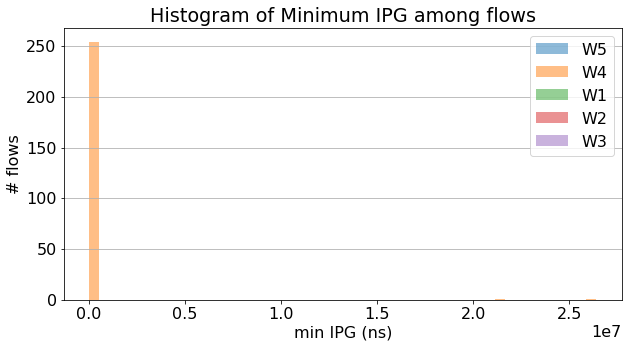

In [8]:
fig, ax1 = plt.subplots(figsize=(10,5))
plots = []
for experiment, flow_min_ipgs in experiment_flow_min_ipgs.items():
    plots.append(ax1.hist(flow_min_ipgs, bins=50, alpha=0.5, label= EXPERIMENT_MAP[experiment]))
ax1.set_ylabel("# flows")
ax1.set_xlabel("min IPG (ns)")
ax1.set_title("Histogram of Minimum IPG among flows")
ax1.grid(axis='y')
plt.legend()
plt.show()

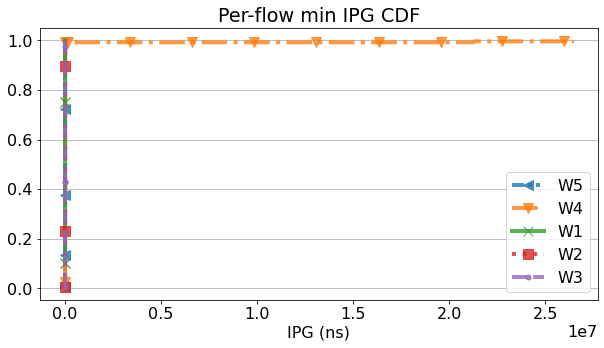

In [9]:
fig, ax1 = plt.subplots(figsize=(10,5))
plots = []
for experiment, flow_min_ipgs in experiment_flow_min_ipgs.items():
    ecdf_f = ECDF(flow_min_ipgs)
    cdf_x = np.linspace(min(flow_min_ipgs), max(flow_min_ipgs), 400000)
    cdf_y = ecdf_f(cdf_x)
    plots.append(ax1.plot(cdf_x, cdf_y, label=EXPERIMENT_MAP[experiment], marker=markers[experiment], markevery=0.1, markersize=10, linestyle=linestyles[experiment], linewidth=4, alpha=0.8))
ax1.set_ylabel("")
ax1.set_xlabel("IPG (ns)")
ax1.set_title("Per-flow min IPG CDF")
ax1.grid(axis='y')
plt.legend()
plt.show()

### Per-flow IPG CDF plot

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


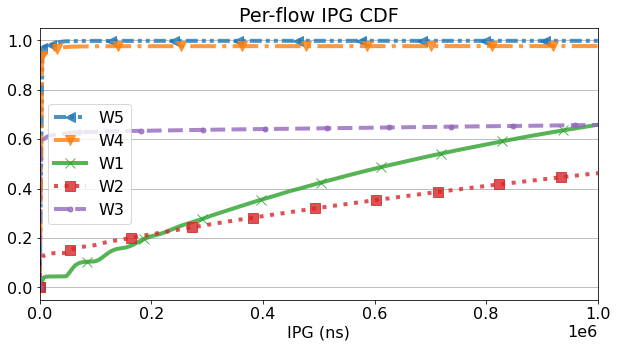

In [11]:
fig, ax1 = plt.subplots(figsize=(10,5))
plots = []
agg_ipgs = {}
for experiment, flow_ipgs in ipg_data.items():
    exp_ipgs = []
    for flow_id, inner_ipgs in flow_ipgs.items():
        for ipg in inner_ipgs:
            exp_ipgs.append(ipg)
    agg_ipgs[experiment] = exp_ipgs
for experiment, exp_ipgs in agg_ipgs.items():
    # if experiment == b'0' or experiment == b'2' or experiment == b'1':
    ecdf_f = ECDF(exp_ipgs)
    cdf_x = np.linspace(min(exp_ipgs), max(exp_ipgs), 400000)
    cdf_y = ecdf_f(cdf_x)
    plots.append(ax1.plot(cdf_x, cdf_y, label=EXPERIMENT_MAP[experiment], marker=markers[experiment], markevery=0.1, markersize=10, linestyle=linestyles[experiment], linewidth=4, alpha=0.8))
ax1.set_ylabel("")
ax1.set_xlim(0, 1000000)
ax1.set_xlabel("IPG (ns)")
ax1.set_title("Per-flow IPG CDF")
ax1.grid(axis='y')
plt.legend()
plt.show()

### Counting the number of bursts

Using the XpYns definition, we use a brute force process to try various values for x and y and find best values according to load intensity.

Modify the below two lists to try different values:

BURST_DIFF_LIST: cut-off thresholds for each burst, in nanoseconds.

BURST_CONSEQUENT_LIST: minimum number of packets that need to have a IPG smaller than BURST_DIFF to be considered a burst.

In [13]:
######################################################
BURST_DIFF_LIST = [128, 256, 512, 1024, 2048]            #
BURST_CONSEQUENT_LIST = [2, 4, 6, 8, 10, 12, 16]     #
######################################################
experiment_names_in_order = []
print('xpyns |\t\t', end='')
for experiment, _ in ts_data.items():
    experiment_names_in_order.append(EXPERIMENT_MAP[experiment])
    print(EXPERIMENT_MAP[experiment], '\t', end='')
print()
heat_map = []
for BURST_DIFF in BURST_DIFF_LIST:
    inner_list = []
    for BURST_CONSEQUENT in BURST_CONSEQUENT_LIST:
        inner_inner_list = []
        print('{}p{}ns |\t'.format(BURST_CONSEQUENT, BURST_DIFF), end='')
        for experiment, _ in ts_data.items():
            bursty_x = {}
            bursty_y = {}
            bursty_legend = []
            b_counter = 0
            cdf_x = []
            cdf_y = []
            bar_x = []
            bar_y = []
            no_of_bursts = 0
            for k,ts in ts_data[experiment].items():
                key_bursty_x = []
                key_bursty_y = []
                b_counter = 0
                for i in range(1, len(ts)):
                    if ts[i] - ts[i-1] < BURST_DIFF:
                        b_counter+=1
                    else:
                        if b_counter >= BURST_CONSEQUENT:
                            key_bursty_x.append(i)
                            key_bursty_y.append(b_counter)
                            no_of_bursts+=1
                            bar_x.append(ts[i-b_counter])
                            bar_y.append(b_counter)
                        # else:
                        #     print(ts[i] - ts[i-1])
                        b_counter = 0
            if no_of_bursts > 0:
                bursty_x[k] = key_bursty_x
                bursty_y[k] = key_bursty_y
                bursty_legend.append(k)
                print("{}\t".format(no_of_bursts), end='')
            else:
                print("0\t", end='')
            inner_inner_list.append(no_of_bursts)
        inner_list.append(inner_inner_list)
        print()
    heat_map.append(inner_list)
normalized_heat_map = heat_map

xpyns |		W5 	W4 	W1 	W2 	W3 	
2p128ns |	0	0	0	0	0	
4p128ns |	0	0	0	0	0	
6p128ns |	0	0	0	0	0	
8p128ns |	0	0	0	0	0	
10p128ns |	0	0	0	0	0	
12p128ns |	0	0	0	0	0	
16p128ns |	0	0	0	0	0	
2p256ns |	0	0	0	0	0	
4p256ns |	0	0	0	0	0	
6p256ns |	0	0	0	0	0	
8p256ns |	0	0	0	0	0	
10p256ns |	0	0	0	0	0	
12p256ns |	0	0	0	0	0	
16p256ns |	0	0	0	0	0	
2p512ns |	11422	12885	4773	9384	14122	
4p512ns |	4995	5623	1104	3055	7132	
6p512ns |	4538	5129	372	1926	5533	
8p512ns |	4522	5074	93	1732	4820	
10p512ns |	4278	4817	40	1323	4079	
12p512ns |	3618	3920	29	995	3318	
16p512ns |	3186	3464	4	642	2623	
2p1024ns |	2523	3377	4697	6551	7482	
4p1024ns |	2120	2989	1175	2264	5118	
6p1024ns |	1982	2832	422	1540	3970	
8p1024ns |	1968	2779	113	1379	3258	
10p1024ns |	1957	2707	54	1212	2793	
12p1024ns |	1930	2651	52	1116	2579	
16p1024ns |	1847	2543	15	953	2263	
2p2048ns |	2015	2996	4694	6372	7208	
4p2048ns |	1976	2904	1178	2155	5024	
6p2048ns |	1914	2827	422	1460	3907	
8p2048ns |	1900	2771	113	1301	3194	
10p2048ns |	1889	2694	55	

### Single burst-parameter analysis

Use the elected parameters (x,y) from above script to prepare a timeseries plot of bursts.

In [14]:
###############################
BURST_DIFF = 2048             #
BURST_CONSEQUENT = 10         #
###############################
experiment_bar_x = {}
experiment_bar_y = {}

for experiment, _ in ts_data.items():
    print("Experiment {} : {}".format(experiment, EXPERIMENT_MAP[experiment]))
    bursty_x = {}
    bursty_y = {}
    bursty_legend = []
    b_counter = 0
    cdf_x = []
    cdf_y = []
    bar_x = []
    bar_y = []
    no_of_bursts = 0
    for k,ts in ts_norm_data[experiment].items():
        key_bursty_x = []
        key_bursty_y = []
        b_counter = 0
        for i in range(1, len(ts)):
            if ts[i] - ts[i-1] < BURST_DIFF:
                b_counter+=1
            else:
                if b_counter >= BURST_CONSEQUENT:
                    key_bursty_x.append(i)
                    key_bursty_y.append(b_counter)
                    no_of_bursts+=1
                    bar_x.append(ts[i-b_counter])
                    bar_y.append(b_counter)
                # else:
                #     print(ts[i] - ts[i-1])
                b_counter = 0
    experiment_bar_x[experiment] = bar_x
    experiment_bar_y[experiment] = bar_y
    if no_of_bursts > 0:
        bursty_x[k] = key_bursty_x
        bursty_y[k] = key_bursty_y
        bursty_legend.append(k)
        print("{}p{}ns: {} total bursts".format(BURST_CONSEQUENT, BURST_DIFF, no_of_bursts))
    else:
        print("No bursts with setting {}p{}ns found".format(BURST_CONSEQUENT, BURST_DIFF))
    print("----------------------")

Experiment b'4' : W5
10p2048ns: 1889 total bursts
----------------------
Experiment b'3' : W4
10p2048ns: 2694 total bursts
----------------------
Experiment b'0' : W1
10p2048ns: 55 total bursts
----------------------
Experiment b'1' : W2
10p2048ns: 1153 total bursts
----------------------
Experiment b'2' : W3
10p2048ns: 2740 total bursts
----------------------


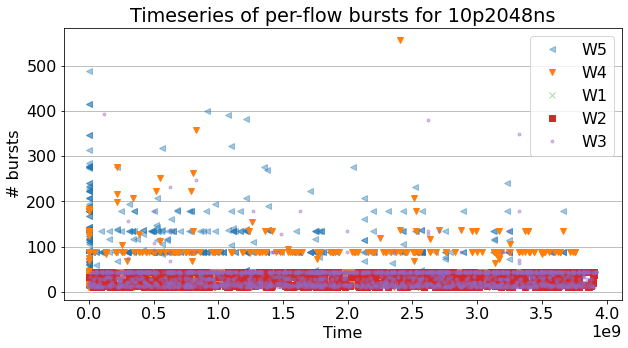

In [15]:
fig, ax1 = plt.subplots(figsize=(10,5))
plots = []
for exp, bar_x in experiment_bar_x.items():
    plots.append(ax1.plot(bar_x, experiment_bar_y[exp], marker=markers[exp], linewidth=0, alpha=alphas[exp], label= EXPERIMENT_MAP[exp]))
ax1.set_ylabel("# bursts")
ax1.set_xlabel("Time")
ax1.set_title("Timeseries of per-flow bursts for {}p{}ns".format(BURST_CONSEQUENT, BURST_DIFF))
ax1.grid(axis='y')
plt.legend()
plt.show()

### Heatmap data normalization

Execute below block to normalize all zeros into 0.1s inorder to smoothen log plots

In [16]:
## normalizing heatmap data for log scale display
normalized_heat_map = []
for i in range(len(heat_map)):
    inner_list = []
    for j in range(len(heat_map[i])):
        inner_inner_list = []
        for k in range(len(heat_map[i][j])):
            if heat_map[i][j][k] == 0:
                inner_inner_list.append(0.1)
            else:
                inner_inner_list.append(heat_map[i][j][k])
                
        inner_list.append(inner_inner_list)
    normalized_heat_map.append(inner_list)
print("Successfully normalized zero values in heatmap data")

Successfully normalized zero values in heatmap data


Execute below block to use raw numbers for heat maps

In [17]:
# normalized_heat_map = heat_map

### Configuration heatmaps: X/Y heatmap based on min burst length

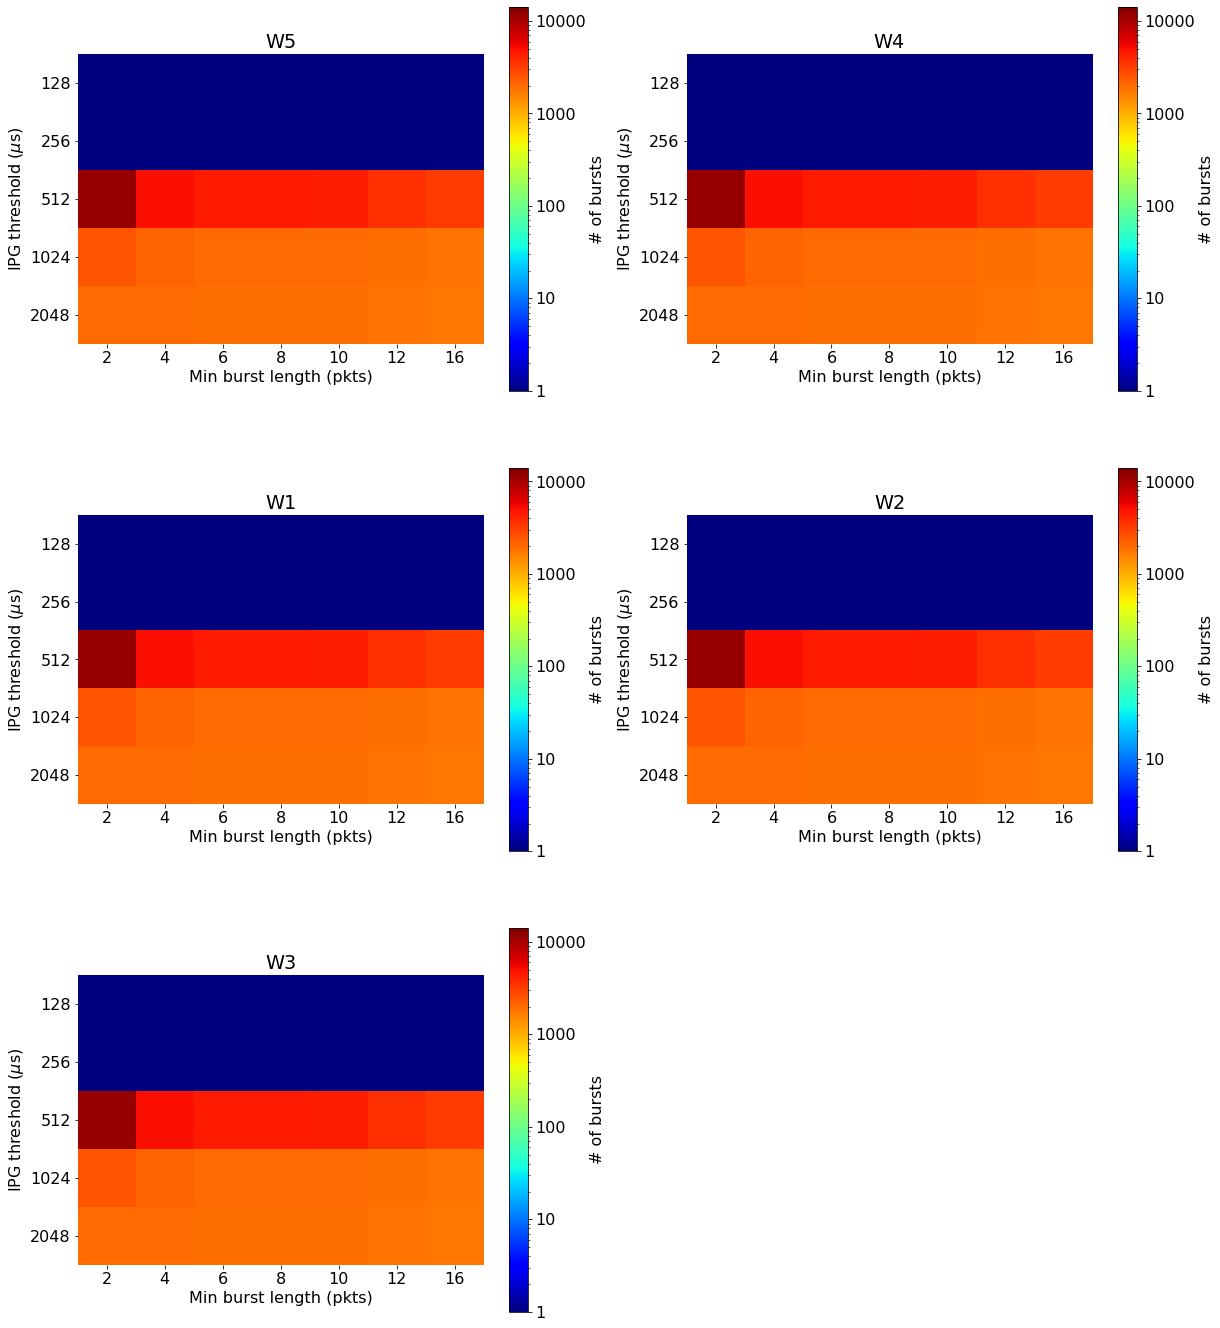

In [18]:
cases = []
case_names = [EXPERIMENT_MAP[i] for i, _ in ts_data.items()]
if len(normalized_heat_map[0][0]) > 0:
    for case in range(len(normalized_heat_map[0][0])):
        case_list = []
        for i in normalized_heat_map:
            inner_list = []
            for j in i:
                inner_list.append(j[0])
            case_list.append(inner_list)
        cases.append(case_list)
p_yticks = BURST_DIFF_LIST
p_xticks = BURST_CONSEQUENT_LIST
nrows = len(cases)//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(20,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(cases):
            ims.append(col.imshow(cases[case_index], cmap='jet', interpolation='none',
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=np.amax(heat_map))))
            # print(col.get_xticks(), col.get_yticks())
            col.yaxis.set_ticks(np.arange(len(p_yticks)))
            col.set_yticklabels(p_yticks)
            col.set_ylabel(r'IPG threshold ($\mu$s)')
            col.xaxis.set_ticks(np.arange(len(BURST_CONSEQUENT_LIST)))
            col.set_xticklabels(p_xticks)
            col.set_xlabel(r'Min burst length (pkts)')
            col.set_title(case_names[case_index])
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Configuration heatmaps: XY/scenario heatmap based on min burst length

Columns in this heatmap can be used to quicly compare the burstiness of different scenarios

['W5', 'W4', 'W1', 'W2', 'W3']
['W5', 'W4', 'W1', 'W2', 'W3']


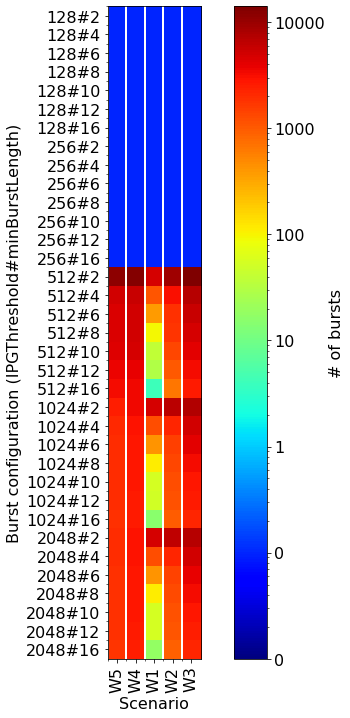

In [19]:
print(case_names)
print(experiment_names_in_order)

cases = []
case_names = []
if len(normalized_heat_map[0][0]) > 0:
    for row in range(len(normalized_heat_map)):
        for col in range(len(normalized_heat_map[row])):
            case_names.append((BURST_DIFF_LIST[row], BURST_CONSEQUENT_LIST[col]))
            cases.append(normalized_heat_map[row][col])

p_xticks = experiment_names_in_order
p_yticks = ['{}#{}'.format(i[0], i[1]) for i in case_names]
fig, col = plt.subplots(figsize=(12,12))
case_index = 0
ims = []

ims.append(col.imshow(cases, cmap='jet', interpolation='nearest', 
                     norm=mpl.colors.LogNorm(vmin=0.01, vmax=np.amax(heat_map))))
col.xaxis.set_ticks(np.arange(len(p_xticks)))
col.set_xticklabels(p_xticks, rotation=90)
col.set_xlabel(r'Scenario')
col.yaxis.set_ticks(np.arange(len(p_yticks)))
col.set_yticklabels(p_yticks)
col.set_ylabel(r'Burst configuration (IPGThreshold#minBurstLength)')
col.set_title("")
col.set_xticks(np.arange(-.5, len(p_xticks) - 1, 1), minor=True)
col.set_yticks(np.arange(-.5, len(p_yticks) - 1, 1), minor=True)
col.grid(axis='x', which='minor', color='w', linestyle='-', linewidth=2)
cbar = col.figure.colorbar(ims[-1])
cbar.set_label('# of bursts')
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())

plt.show()

### Configuration heatmaps: X/Scenario heatmap based on min burst length

Each heatmap is drawn for one IPG threshold.

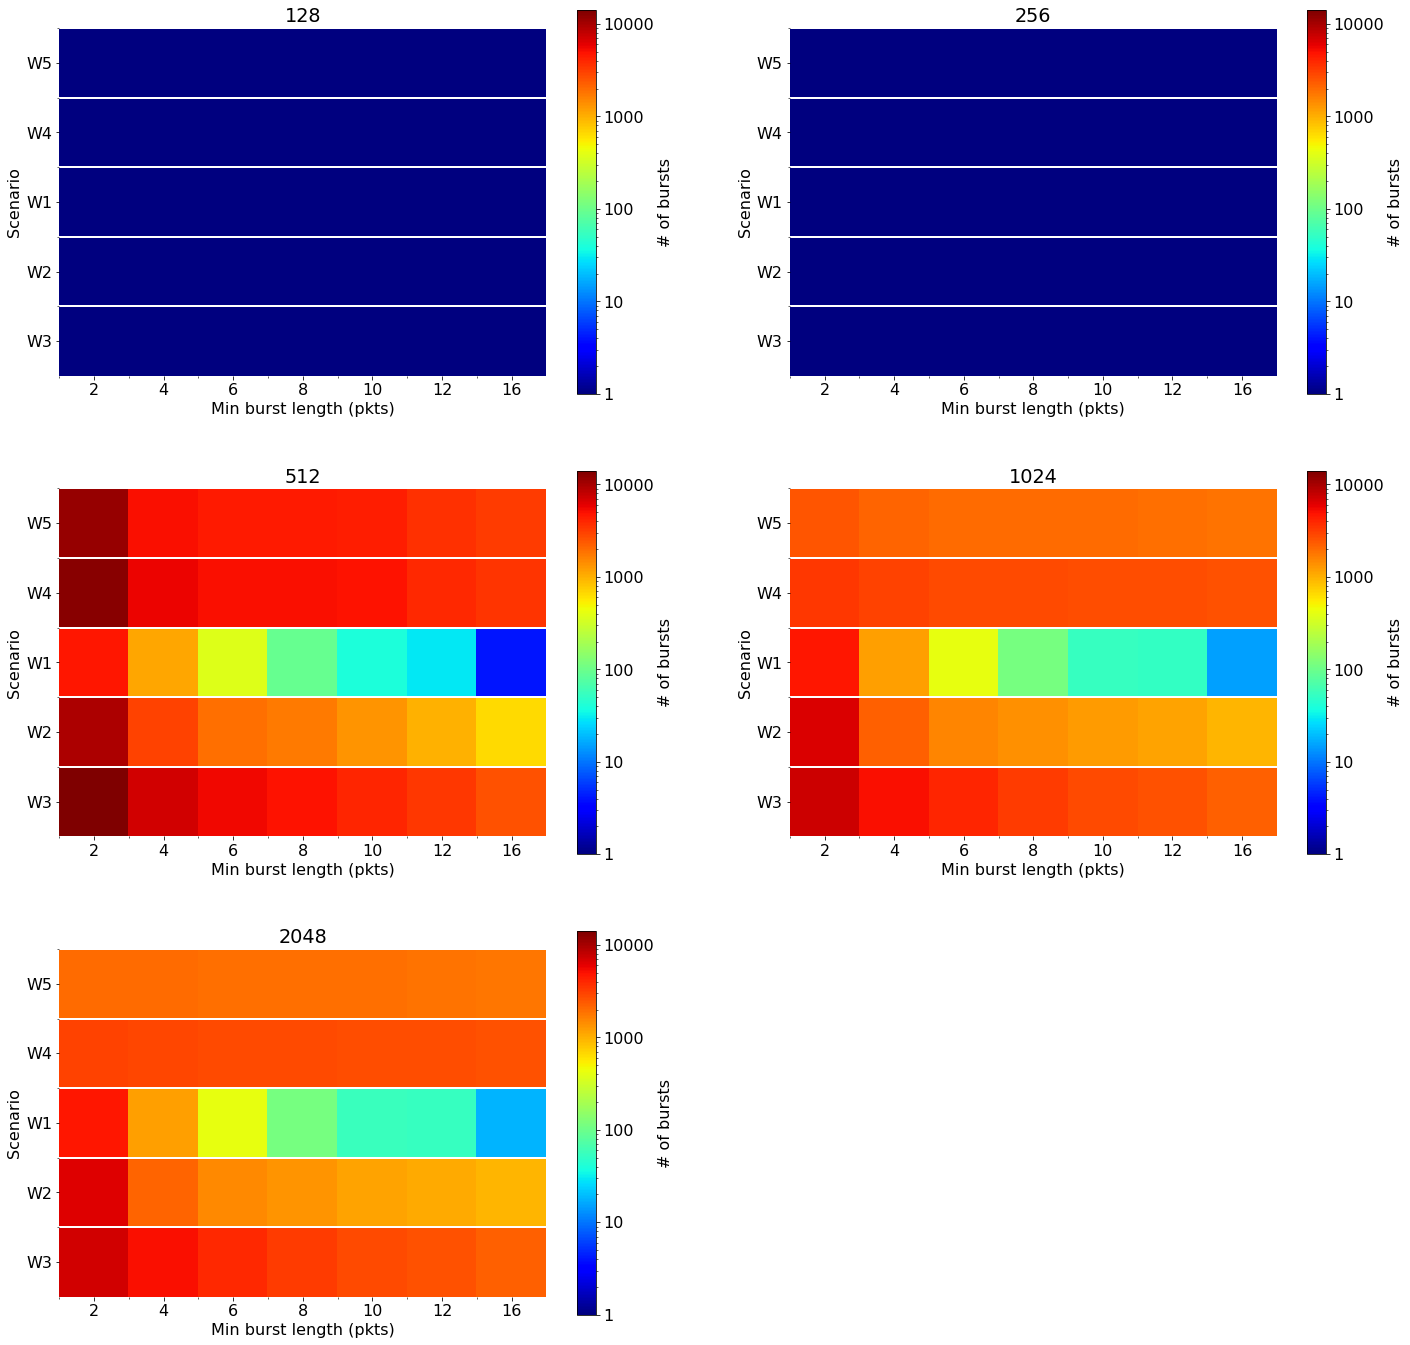

In [20]:
BURST_DIFF_LIST = [128, 256, 512, 1024, 2048]         #
BURST_CONSEQUENT_LIST = [2, 4, 6, 8, 10, 12, 16] 
cases = []
case_names = BURST_DIFF_LIST
if len(normalized_heat_map[0][0]) > 0:
    for case in range(len(normalized_heat_map)):
        case_list = []
        for i in normalized_heat_map[case]:
            inner_list = []
            for j in i:
                inner_list.append(j)
            case_list.append(inner_list)
        cases.append(case_list)
p_yticks = []
p_yticks = [EXPERIMENT_MAP[i] for i, _ in ts_data.items()]
p_xticks = BURST_CONSEQUENT_LIST
nrows = len(cases)//2 +1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(24,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(cases):
            ims.append(col.imshow(np.transpose(cases[case_index]), cmap='jet', interpolation='nearest', 
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=np.amax(heat_map))))
            col.xaxis.set_ticks(np.arange(len(BURST_CONSEQUENT_LIST)))
            col.set_xticklabels(p_xticks)
            col.set_xlabel(r'Min burst length (pkts)')
            col.yaxis.set_ticks(np.arange(len(p_yticks)))
            col.set_yticklabels(p_yticks)
            col.set_ylabel(r'Scenario')
            col.set_title(case_names[case_index])
            col.set_xticks(np.arange(-.5, len(BURST_CONSEQUENT_LIST) - 1, 1), minor=True)
            col.set_yticks(np.arange(-.5, len(case_names) - 1, 1), minor=True)
            col.grid(axis='y', which='minor', color='w', linestyle='-', linewidth=2)
            for spine in col.spines.values():
                spine.set_visible(False)
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            case_index+=1
        else:
            col.axis('off')

# ax1.set_ylabel("y")
# ax1.set_xlabel("x")
# ax1.set_title("Heatmap of per-flow configurations")
# plt.legend()
plt.show()

### Timeseries of bursts based on user-defined X and Y values

Tracks the burstiness through time for all scenarios.


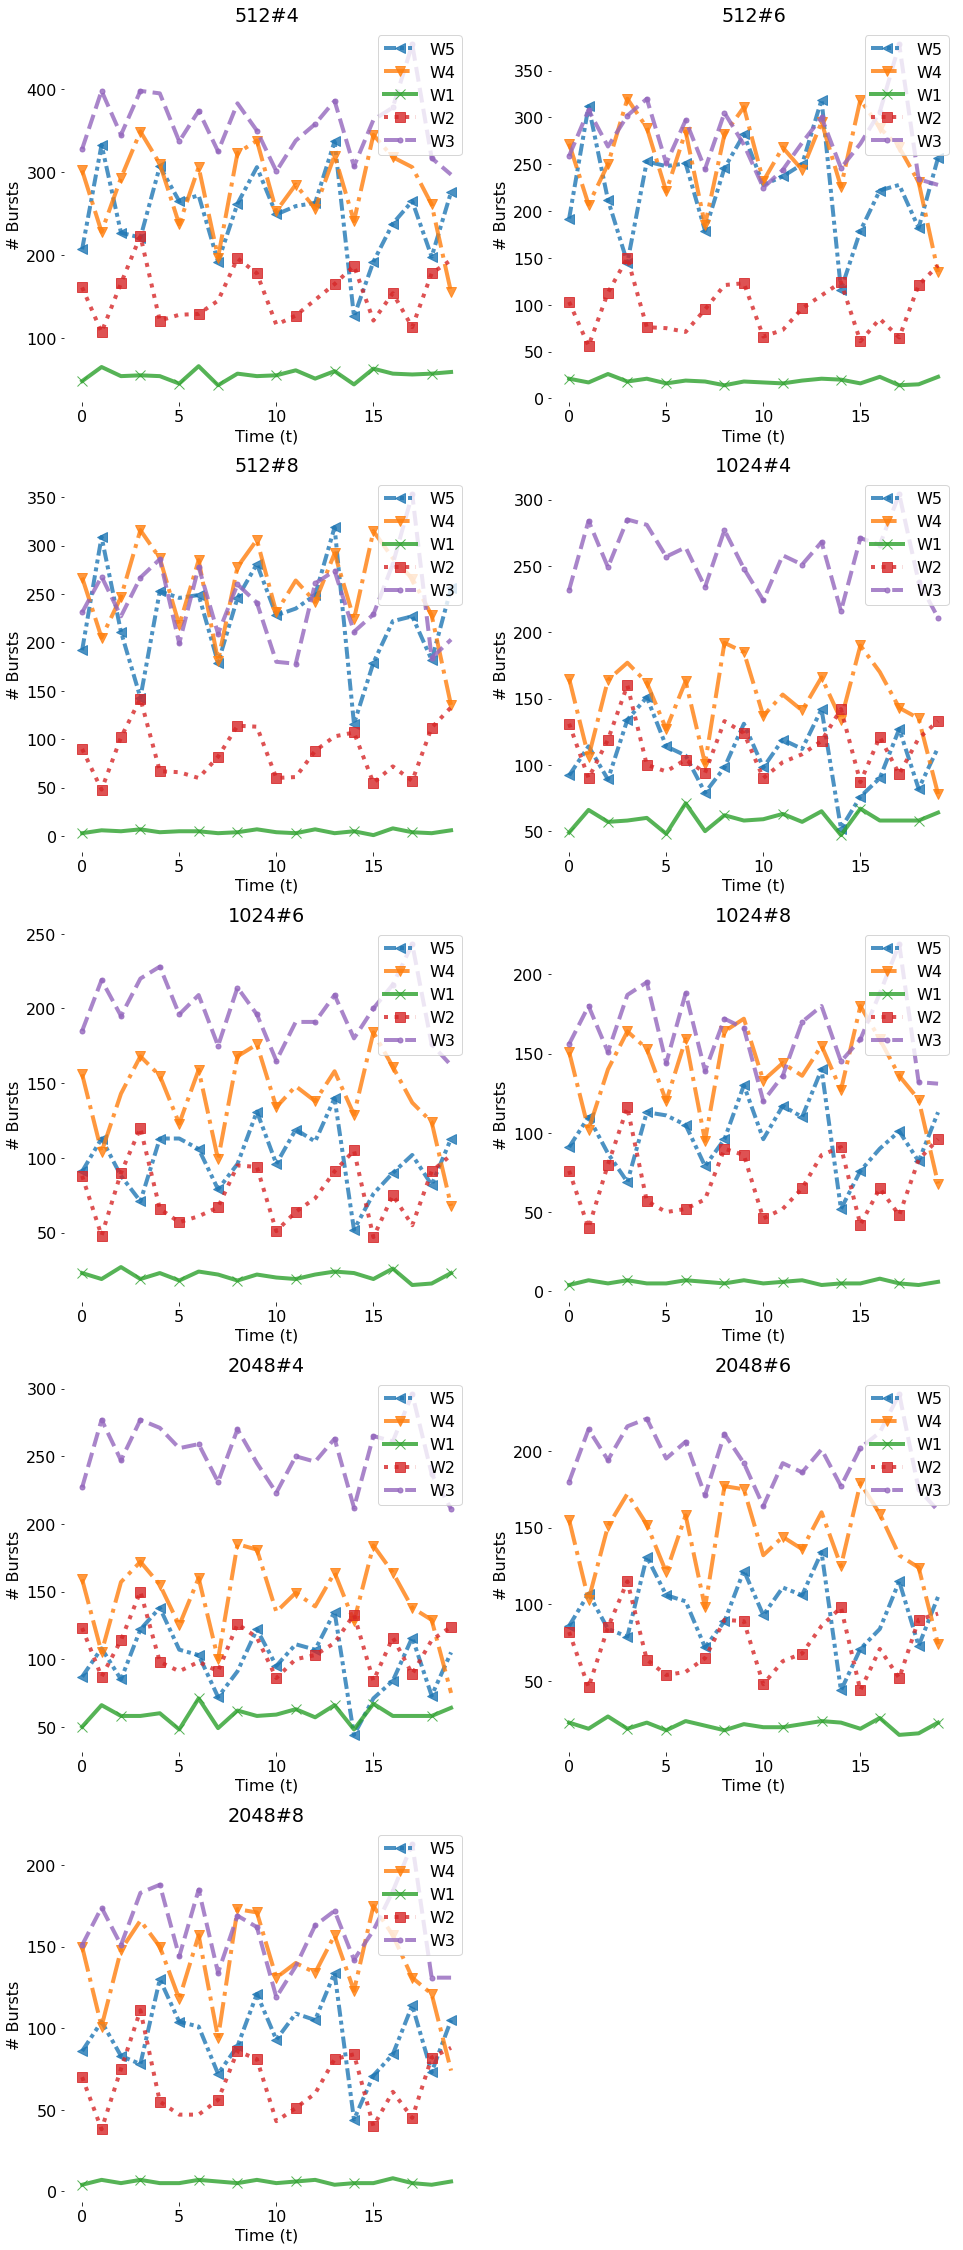

In [21]:
######################################################
BURST_DIFF_LIST_TS = [512, 1024, 2048]            #
BURST_CONSEQUENT_LIST_TS = [4,6,8]     #
BINS = 20
######################################################
subplots_total = len(BURST_DIFF_LIST_TS) * len(BURST_CONSEQUENT_LIST_TS)
plots_x = []
tseries_data = []
exp_order = []
for diff in BURST_DIFF_LIST_TS:
    for cons in BURST_CONSEQUENT_LIST_TS:
        experiment_ts_list = []
        for experiment, _ in ts_data.items():
            ts_list = []
            no_of_bursts = 0
            exp_order.append(experiment)
            for k,ts in ts_data[experiment].items():
                b_counter = 0
                for i in range(1, len(ts)):
                    if ts[i] - ts[i-1] < diff:
                        b_counter+=1
                    else:
                        if b_counter >= cons:
                            no_of_bursts+=1
                            ts_list.append(ts[i-b_counter])
                        b_counter = 0
            experiment_ts_list.append(ts_list)
        plots_x.append((diff, cons))
        tseries_data.append(experiment_ts_list)
# post-process ts data
plots_y = []
for config in range(len(tseries_data)):
    config_exps = []
    for exp in range(len(tseries_data[config])):
        processed_tseries = np.histogram(tseries_data[config][exp], bins=BINS)
        config_exps.append(processed_tseries[0])
    plots_y.append(config_exps)
        
fig, ax = plt.subplots(nrows= subplots_total//2 + 1, ncols=2, figsize=(16,8*(subplots_total//2 + 1)), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(plots_y):
            config_ims = []
            for exp in range(len(plots_y[case_index])):
                # print(len(exp[1]))
                experiment = exp_order[exp]
                ims.append(col.plot(np.arange(BINS), plots_y[case_index][exp],
                                    label=EXPERIMENT_MAP[exp_order[exp]],
                                    marker=markers[experiment], markevery=0.1, markersize=10, linestyle=linestyles[experiment],
                                    linewidth=4, alpha=0.8))
            ims.append(config_ims)
            col.set_xlabel(r'Time (t)')
            col.set_ylabel(r'# Bursts')
            col.set_title('{}#{}'.format(plots_x[case_index][0], plots_x[case_index][1]))

            col.legend()
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')
# plt.legend()
plt.show()

### Bar chart of burst lengths for all scenarios

Each plot belongs to one IPG threshold.

Modify `SELECTED_LENGTHS` list to displays bursts of arbitrary lengths.

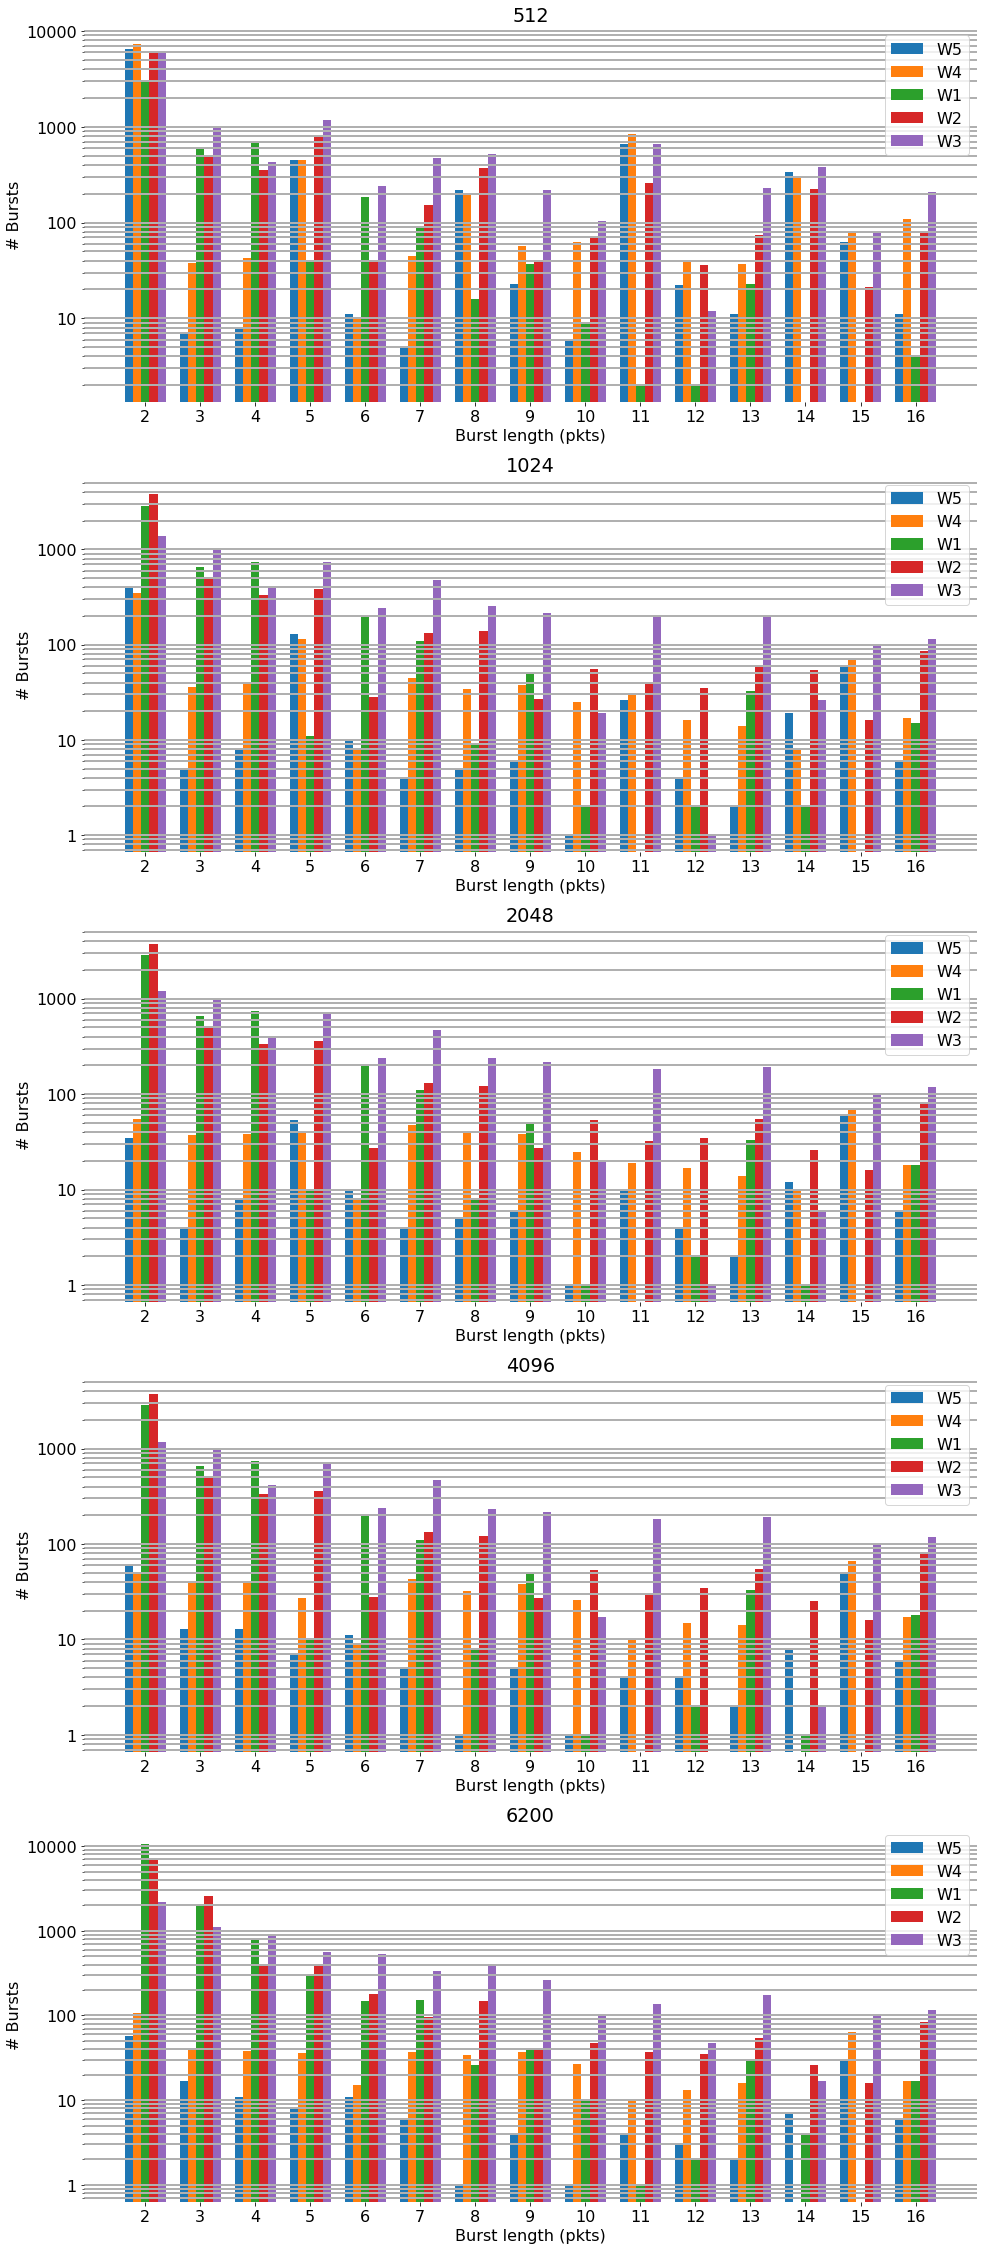

In [22]:
######################################################
BURST_DIFF_LIST = [512, 1024, 2048, 4096, 6200]        # 128, 256, 512, 1024, 2048
SELECTED_LENGTHS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] 
######################################################
experiment_names_in_order = []
histogram = {}
for BURST_DIFF in BURST_DIFF_LIST:
    inner_list = []
    experiment_names_in_order = []
    histogram[BURST_DIFF] = {}
    for experiment, _ in ts_data.items():
        experiment_names_in_order.append(EXPERIMENT_MAP[experiment])
        no_of_bursts = 0
        b_counter = 0
        histogram[BURST_DIFF][experiment] = {}
        for k,ts in ts_data[experiment].items():
            b_counter = 0
            for i in range(1, len(ts)):
                if ts[i] - ts[i-1] < BURST_DIFF:
                    b_counter+=1
                else:
                    if b_counter >= 2:
                        if b_counter in histogram[BURST_DIFF][experiment]:
                            histogram[BURST_DIFF][experiment][b_counter] += 1
                        else:
                            histogram[BURST_DIFF][experiment][b_counter] = 1
                    b_counter = 0
                    
plot_data = {}
for k, v in histogram.items():
    plot_data[k] = []
    exp_idx = 0
    for experiment, exp_map in v.items():
        plot_data[k].append([])
        for i in SELECTED_LENGTHS:
            if i in exp_map:
                plot_data[k][exp_idx].append(exp_map[i])
            else:
                plot_data[k][exp_idx].append(0)
        exp_idx += 1
            

X = np.arange(len(SELECTED_LENGTHS))
p_yticks = []
p_yticks = [EXPERIMENT_MAP[i] for i, _ in ts_data.items()]
p_xticks = BURST_CONSEQUENT_LIST
number_of_cases = len(BURST_DIFF_LIST)
fig, ax = plt.subplots(nrows= number_of_cases, ncols=1, figsize=(16,8*number_of_cases), squeeze=False)
case_index = 0
STEP = 0.15
ims = []
for row in ax:
    for col in row:
        if case_index < number_of_cases:
            ims.append([])
            labels = []
            position = -((len(plot_data[BURST_DIFF_LIST[case_index]])//2) * STEP)
            for item in range(len(plot_data[BURST_DIFF_LIST[case_index]])):
                ims[case_index].append(col.bar(X + position, plot_data[BURST_DIFF_LIST[case_index]][item],
                                               width=0.15, label=experiment_names_in_order[item]))
                position += STEP
                labels.append(experiment_names_in_order[item])
            col.set_yscale('log')
            col.yaxis.set_major_formatter(ScalarFormatter())
            col.xaxis.set_ticks(np.arange(len(SELECTED_LENGTHS)))
            col.set_xticklabels(SELECTED_LENGTHS)
            col.set_xlabel(r'Burst length (pkts)')
            col.set_ylabel(r'# Bursts')
            col.set_title('{}'.format(BURST_DIFF_LIST[case_index]))
            col.legend(ims[case_index], labels)
            col.grid(axis='y', which='both', linestyle='-', linewidth=2)
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Heatmap of burst lengths grouped by IPG thresholds.

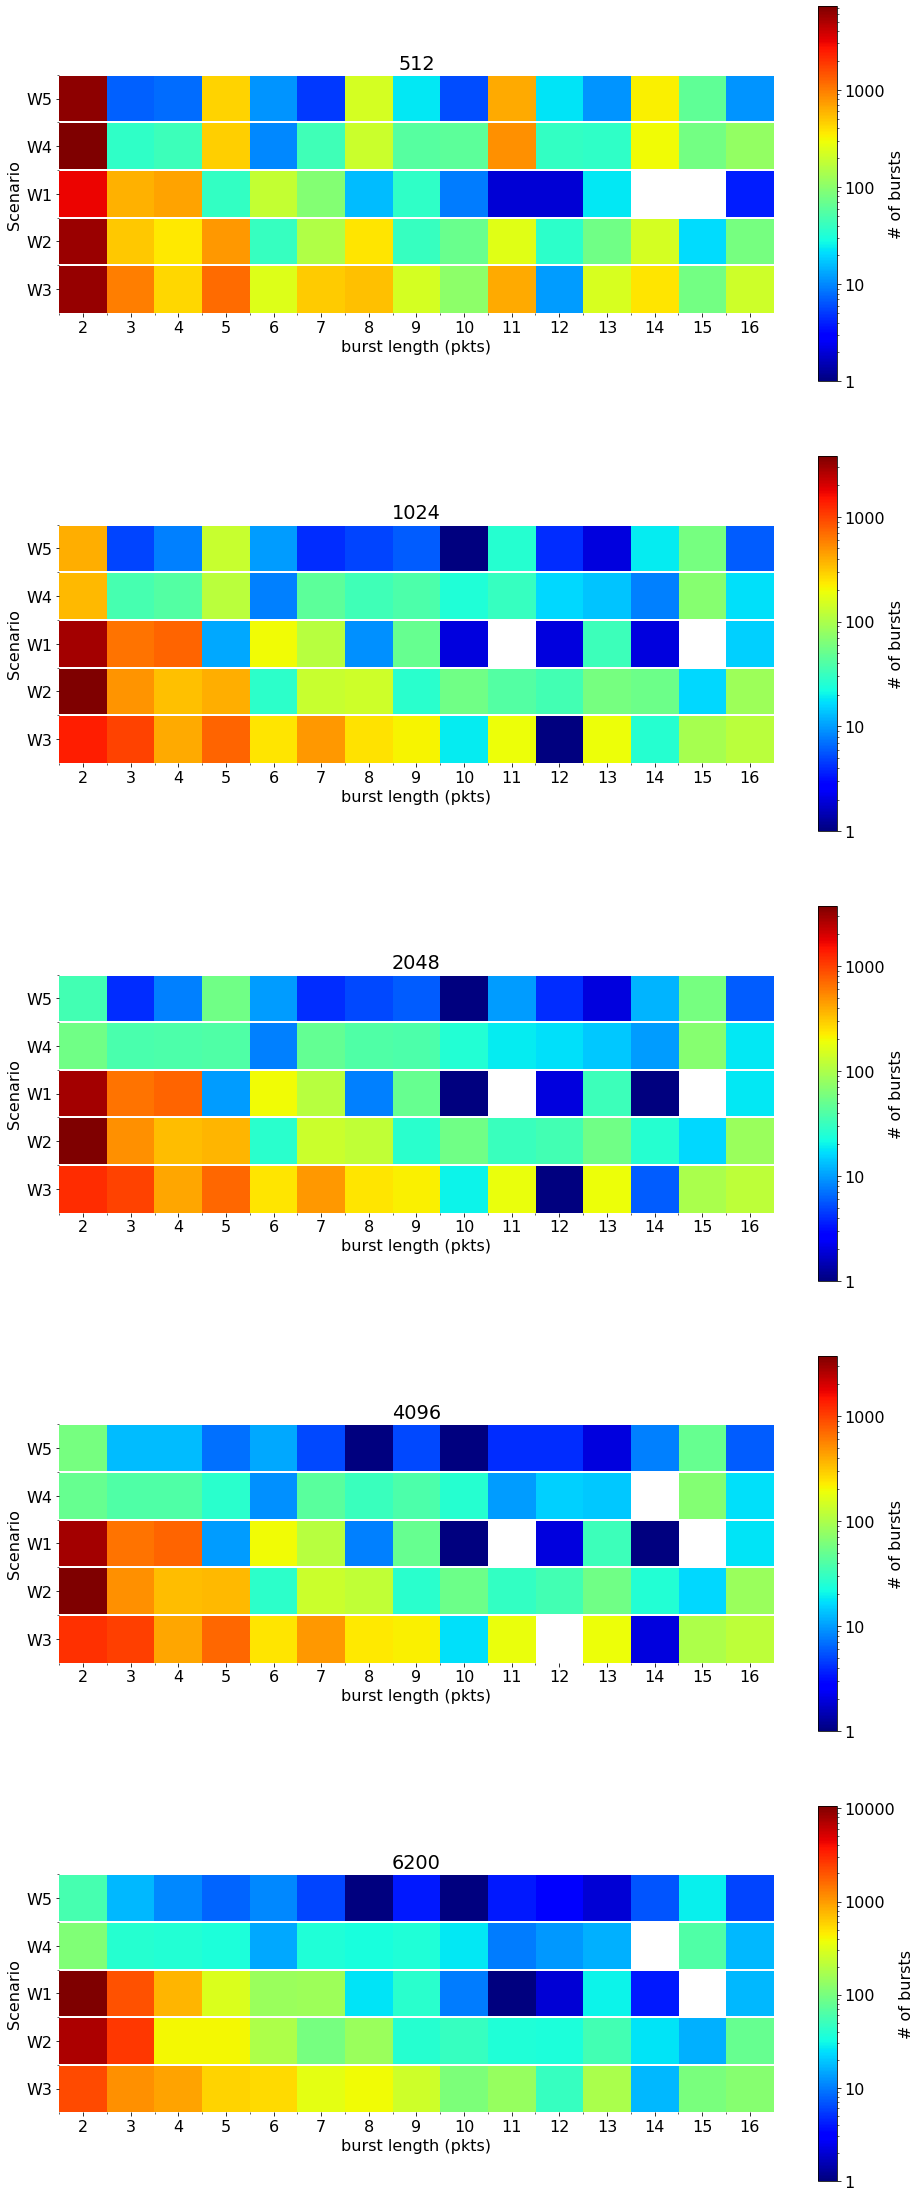

In [23]:
fig, ax = plt.subplots(nrows= len(BURST_DIFF_LIST), ncols=1, figsize=(16,8*len(BURST_DIFF_LIST)), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            ims.append(col.imshow(plot_data[BURST_DIFF_LIST[case_index]], cmap='jet', interpolation='nearest', 
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=np.amax(plot_data[BURST_DIFF_LIST[case_index]]))))
            col.xaxis.set_ticks(np.arange(len(SELECTED_LENGTHS)))
            col.set_xticklabels(SELECTED_LENGTHS)
            col.set_xlabel(r'burst length (pkts)')
            col.yaxis.set_ticks(np.arange(len(experiment_names_in_order)))
            col.set_yticklabels(experiment_names_in_order)
            col.set_ylabel(r'Scenario')
            col.set_title(BURST_DIFF_LIST[case_index])
            col.set_xticks(np.arange(-.5, len(SELECTED_LENGTHS) - 1, 1), minor=True)
            col.set_yticks(np.arange(-.5, len(experiment_names_in_order) - 1, 1), minor=True)
            col.grid(axis='y', which='minor', color='w', linestyle='-', linewidth=2)
            for spine in col.spines.values():
                spine.set_visible(False)
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            case_index+=1
        else:
            col.axis('off')

# ax1.set_ylabel("y")
# ax1.set_xlabel("x")
# ax1.set_title("Heatmap of per-flow configurations")
# plt.legend()
plt.show()

### Stacked bar chart of burst lengths

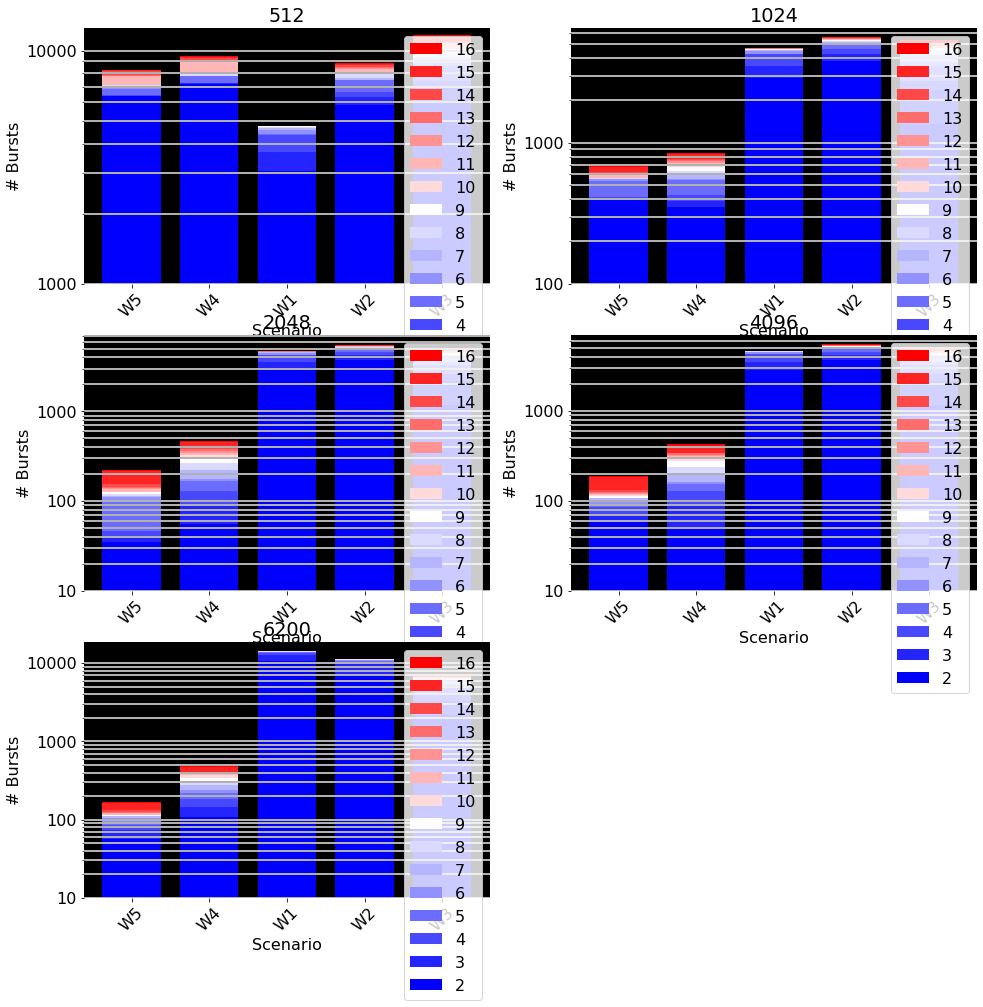

In [24]:
number_of_cases = len(BURST_DIFF_LIST)
fig, ax = plt.subplots(nrows= number_of_cases//2 + 1, ncols=2, figsize=(16,16), squeeze=False)
case_index = 0
STEP = 0.75
ims = []
stacked_colors = mpl.cm.bwr(np.linspace(0, 1, len(SELECTED_LENGTHS)))
for row in ax:
    for col in row:
        if case_index < number_of_cases:
            y_offset = np.zeros(len(experiment_names_in_order))
            X = np.arange(len(experiment_names_in_order))
            labels = []
            for item in range(len(SELECTED_LENGTHS)):
                data = np.transpose(plot_data[BURST_DIFF_LIST[case_index]])
                ims.append(col.bar(X, data[item], width=STEP, label=SELECTED_LENGTHS[item],
                                               bottom=y_offset, color=stacked_colors[item]))
                y_offset = y_offset + data[item]
            col.set_yscale('log')
            col.yaxis.set_major_formatter(ScalarFormatter())
            col.xaxis.set_ticks(np.arange(len(experiment_names_in_order)))
            col.set_xticklabels(experiment_names_in_order, rotation=45)
            col.set_xlabel(r'Scenario')
            col.set_ylabel(r'# Bursts')
            col.set_title('{}'.format(BURST_DIFF_LIST[case_index]))
            col.legend(SELECTED_LENGTHS)
            handles, labels = col.get_legend_handles_labels()
            col.legend(reversed(handles), reversed(labels))
            col.grid(axis='y', which='both', linestyle='-', linewidth=2)
            col.set_facecolor('k')
            col.set_ylim(10**int(np.log10(col.get_ylim()[0])), col.get_ylim()[1])
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Heatmap of burst lengths grouped by scenarios

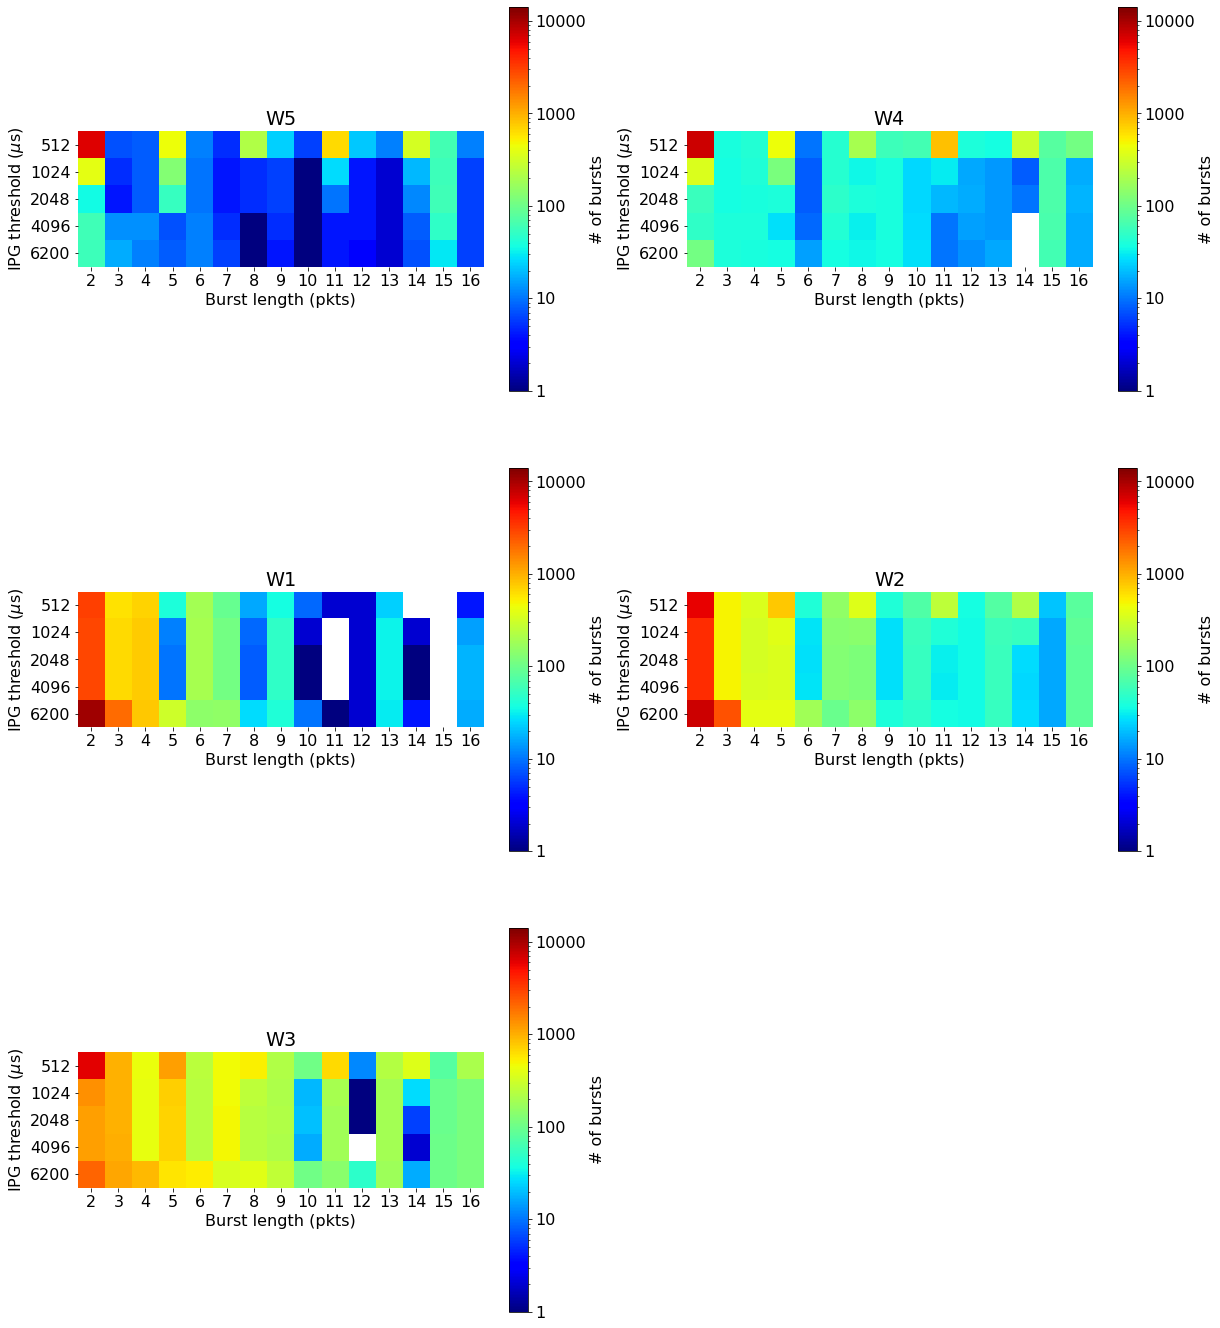

In [25]:
cases = []
scenario_plot_data = {}
for ipg, ipg_val in histogram.items():
    for exp, exp_map in ipg_val.items():
        if exp not in scenario_plot_data:
            cases.append(exp)
            scenario_plot_data[exp] = [[] for i in range(len(BURST_DIFF_LIST))]
            
for ipg in range(len(BURST_DIFF_LIST)):
    for l in range(len(SELECTED_LENGTHS)):
        ipg_val = histogram[BURST_DIFF_LIST[ipg]]
        exp_idx = 0
        for exp, exp_map in ipg_val.items():
            if SELECTED_LENGTHS[l] in exp_map:
                scenario_plot_data[exp][ipg].append(exp_map[SELECTED_LENGTHS[l]])
            else:
                scenario_plot_data[exp][ipg].append(0)
            exp_idx+=1        

b_maxes = []
for exp_b_lengths in heat_map:
    for exp in range(len(exp_b_lengths)):
        try:
            b_maxes.append(np.amax(exp_b_lengths[exp]))
        except ValueError:
            pass
    
b_max = np.max(b_maxes)
max_val = np.max(b_maxes)
            
nrows = len(cases)//2 + 1
fig, ax = plt.subplots(nrows= len(cases)//2 + 1, ncols=2, figsize=(20,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(cases):
            ims.append(col.imshow(scenario_plot_data[cases[case_index]], cmap='jet', interpolation='none',
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=max_val)))
            col.yaxis.set_ticks(np.arange(len(BURST_DIFF_LIST)))
            col.set_yticklabels(BURST_DIFF_LIST)
            col.set_ylabel(r'IPG threshold ($\mu$s)')
            col.xaxis.set_ticks(np.arange(len(SELECTED_LENGTHS)))
            col.set_xticklabels(SELECTED_LENGTHS)
            col.set_xlabel(r'Burst length (pkts)')
            col.set_title(experiment_names_in_order[case_index])
            for spine in col.spines.values():
                spine.set_visible(False)
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Measuring bursts in Bytes: Burst length CDFs

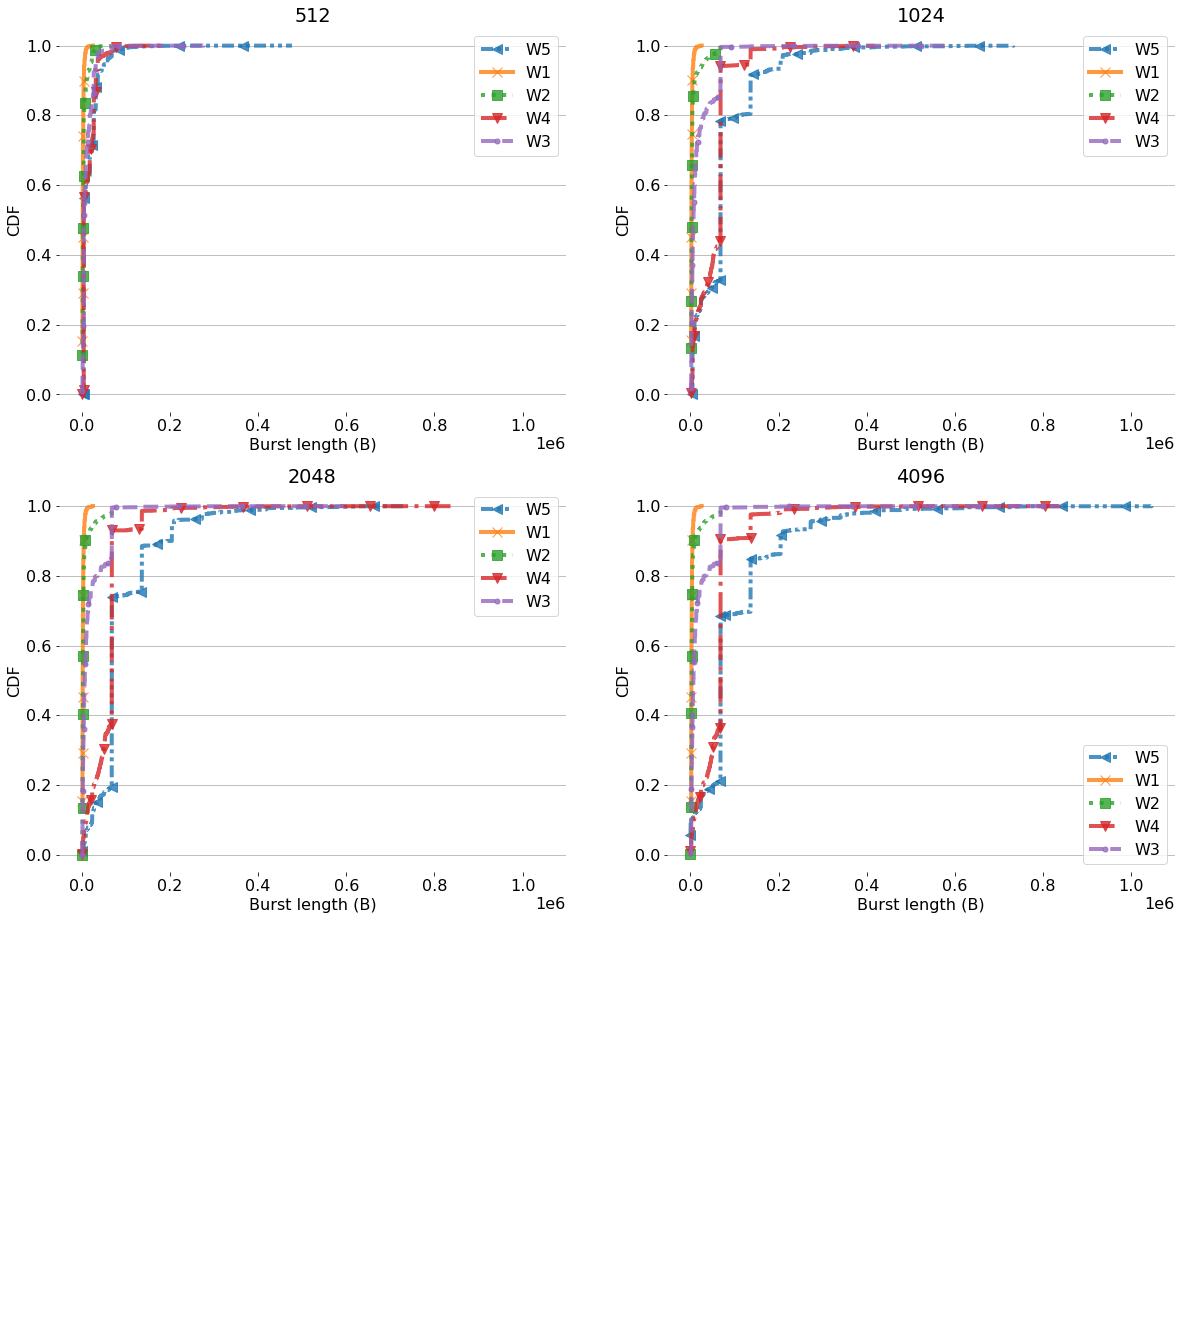

In [3]:
BURST_DIFF_LIST = [512, 1024, 2048, 4096, 6200, 7400, 8500, 10000]        # 128, 256, 512, 1024, 2048
BURST_DIFF_LIST = [512, 1024, 2048, 4096] 

ts_sizes = get_ts_sizes_all_keys(entries)
experiment_names_in_order = []
exp_keys = []
for experiment, _ in ts_data.items():
    experiment_names_in_order.append(EXPERIMENT_MAP[experiment])
    exp_keys.append(experiment)

cdf_map = {}
for BURST_DIFF in BURST_DIFF_LIST:
    inner_list = []
    for experiment, _ in ts_data.items():
        experiment_burst_lengths = []
        for k,ts in ts_data[experiment].items():
            b_counter = 0
            no_of_bursts = 0
            burst_size = 0
            burst_first_packet_size = ts_sizes[experiment][k][0]
            for i in range(1, len(ts)):
                if ts[i] - ts[i-1] < BURST_DIFF:
                    b_counter+=1
                    burst_size += ts_sizes[experiment][k][i]
                else:
                    if b_counter >= 1:
                        no_of_bursts+=1
                        burst_size += burst_first_packet_size
                        experiment_burst_lengths.append(burst_size)
                    burst_first_packet_size = ts_sizes[experiment][k][i]
                    burst_size = 0
                    b_counter = 0
        inner_list.append(experiment_burst_lengths)
    cdf_map[BURST_DIFF] = inner_list
    
nrows = len(BURST_DIFF_LIST)//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(20,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            ims.append([])
            for exp in range(len(cdf_map[BURST_DIFF_LIST[case_index]])):
                burst_lengths = cdf_map[BURST_DIFF_LIST[case_index]][exp]
                if len(burst_lengths) == 0:
                    continue
                ecdf_f = ECDF(burst_lengths)
                cdf_x = np.linspace(min(burst_lengths), max(burst_lengths), 400000)
                cdf_y = ecdf_f(cdf_x)
                experiment = exp_keys[exp]
                ims[case_index].append(col.plot(cdf_x, cdf_y, label=EXPERIMENT_MAP[experiment],
                                                marker=markers[experiment], markevery=0.1, markersize=10,
                                                linestyle=linestyles[experiment], linewidth=4, alpha=0.8))
            col.set_ylabel(r'CDF')
            col.set_xlabel(r'Burst length (B)')
            col.set_title(BURST_DIFF_LIST[case_index])
            col.grid(axis='y')
            if len(ims[case_index]) > 0:
                col.legend()
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

case_index = 0
min_x = None
max_x = None
min_y = None
max_y = None
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            case_index += 1
            (x_mi, x_ma) = col.get_xlim()
            (y_mi, y_ma) = col.get_ylim()
            if min_x is None or x_mi < min_x:
                min_x = x_mi
            if max_x is None or x_ma > max_x:
                max_x = x_ma
            if min_y is None or y_mi < min_y:
                min_y = y_mi
            if max_y is None or y_ma > max_y:
                max_y = y_ma
                
case_index = 0
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            case_index += 1
            col.set_xlim(min_x, max_x)
            col.set_ylim(min_y, max_y)

plt.show()


### CCDF plots for burst lengths

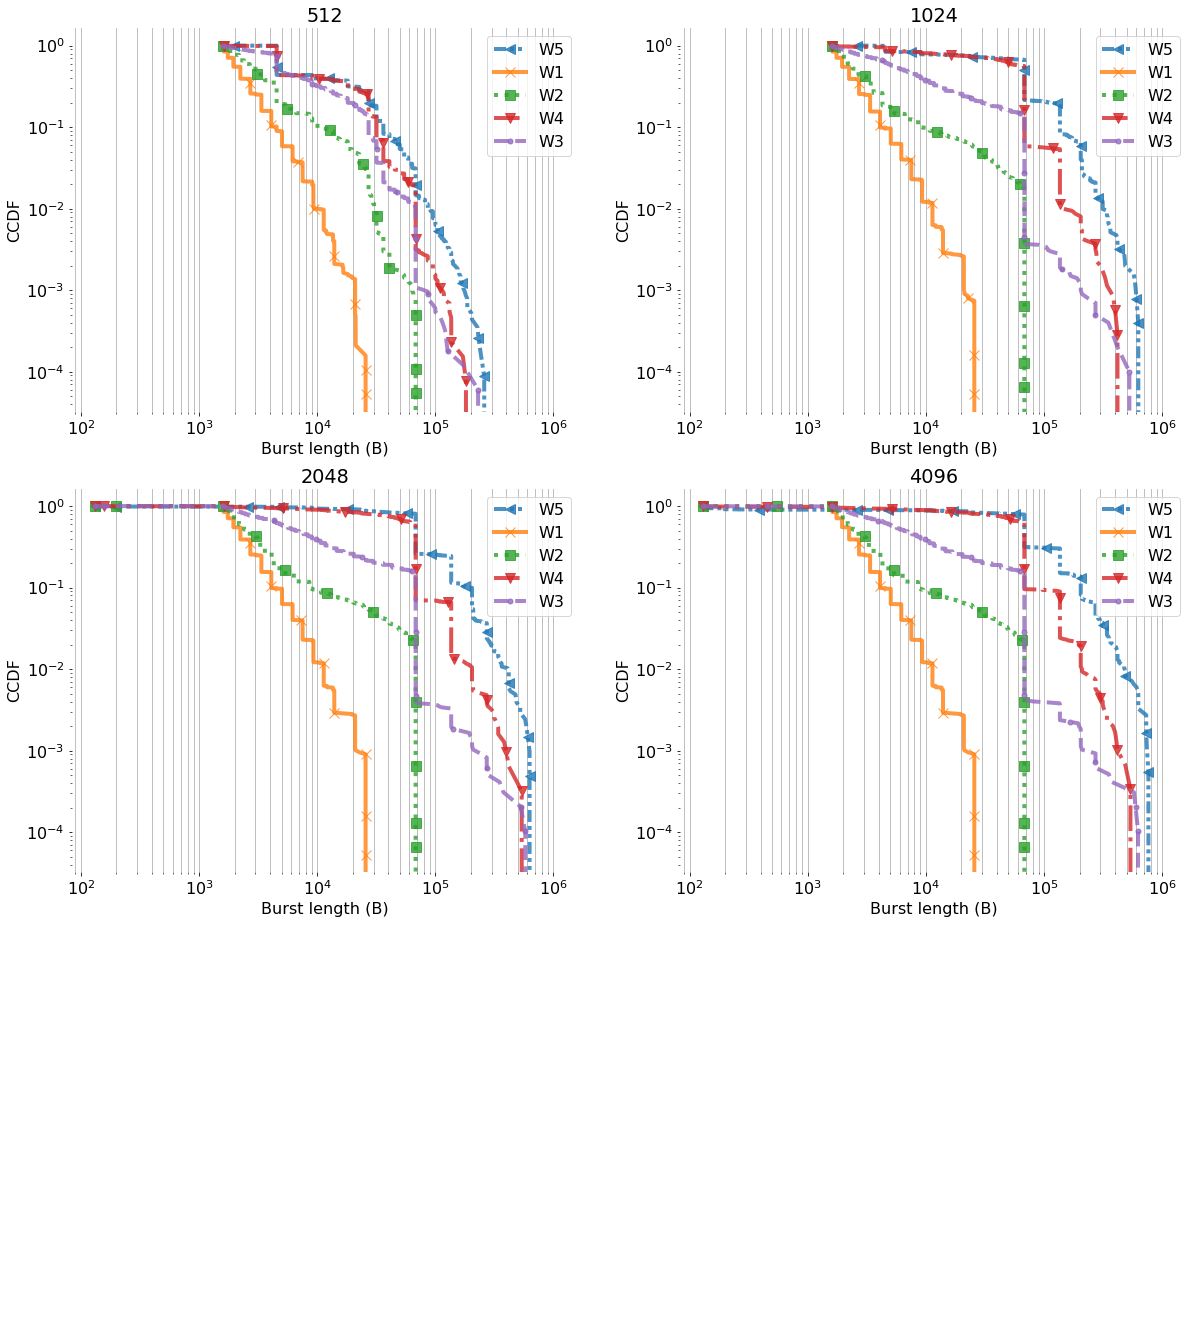

In [4]:
import numpy as np

BURST_DIFF_LIST = [512, 1024, 2048, 4096, 6200, 7400, 8500, 10000]        # 128, 256, 512, 1024, 2048
BURST_DIFF_LIST = [512, 1024, 2048, 4096] 

def get_ccdf(data):

    x = np.append([min(data)-1.0], np.sort(data))
    y = 1 - np.arange(0,len(data)+1) / len(data)

    return x, y

ts_sizes = get_ts_sizes_all_keys(entries)
experiment_names_in_order = []
exp_keys = []
for experiment, _ in ts_data.items():
    experiment_names_in_order.append(EXPERIMENT_MAP[experiment])
    exp_keys.append(experiment)

cdf_map = {}
for BURST_DIFF in BURST_DIFF_LIST:
    inner_list = []
    for experiment, _ in ts_data.items():
        experiment_burst_lengths = []
        for k,ts in ts_data[experiment].items():
            b_counter = 0
            no_of_bursts = 0
            burst_size = 0
            burst_first_packet_size = ts_sizes[experiment][k][0]
            for i in range(1, len(ts)):
                if ts[i] - ts[i-1] < BURST_DIFF:
                    b_counter+=1
                    burst_size += ts_sizes[experiment][k][i]
                else:
                    if b_counter >= 1:
                        no_of_bursts+=1
                        burst_size += burst_first_packet_size
                        experiment_burst_lengths.append(burst_size)
                    burst_first_packet_size = ts_sizes[experiment][k][i]
                    burst_size = 0
                    b_counter = 0
        inner_list.append(experiment_burst_lengths)
    cdf_map[BURST_DIFF] = inner_list
    
nrows = len(BURST_DIFF_LIST)//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(20,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            ims.append([])
            for exp in range(len(cdf_map[BURST_DIFF_LIST[case_index]])):
                burst_lengths = cdf_map[BURST_DIFF_LIST[case_index]][exp]
                if len(burst_lengths) == 0:
                    continue
                # ecdf_f = ECDF(burst_lengths)
                # cdf_x2 = np.linspace(min(burst_lengths), max(burst_lengths), 400000)
                # cdf_x = [1-i for i in cdf_x2]
                # cdf_y = ecdf_f(cdf_x2)
                cdf_x, cdf_y = get_ccdf(burst_lengths)
                experiment = exp_keys[exp]
                ims[case_index].append(col.plot(cdf_x, cdf_y, label=EXPERIMENT_MAP[experiment],
                                                marker=markers[experiment], markevery=0.1, markersize=10,
                                                linestyle=linestyles[experiment], linewidth=4, alpha=0.8))
            col.set_ylabel(r'CCDF')
            col.set_xlabel(r'Burst length (B)')
            col.set_title(BURST_DIFF_LIST[case_index])
            col.grid(axis='x', which='both')
            col.set_xscale("log")
            col.set_yscale("log")
            if len(ims[case_index]) > 0:
                col.legend()
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

case_index = 0
min_x = None
max_x = None
min_y = None
max_y = None
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            case_index += 1
            (x_mi, x_ma) = col.get_xlim()
            (y_mi, y_ma) = col.get_ylim()
            if min_x is None or x_mi < min_x:
                min_x = x_mi
            if max_x is None or x_ma > max_x:
                max_x = x_ma
            if min_y is None or y_mi < min_y:
                min_y = y_mi
            if max_y is None or y_ma > max_y:
                max_y = y_ma
                
case_index = 0
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            case_index += 1
            col.set_xlim(min_x, max_x)
            col.set_ylim(min_y, max_y)
            
plt.show()


In [5]:
## process packet sizes per flow
def get_size_timeseries_all_keys(entries_all: dict):
    size_data = {}
    for key, entries in entries_all.items():
        size_data[key] = []
        start = 0
        for flow, timestamps in entries.items():
            for entry in timestamps:
                if start == 0:
                    start = entry.ingress_global
                if entry.ingress_global - start < 2000000000:
                    size_data[key].append((entry.ingress_global, entry.packet_length))
                else:
                    break
    return size_data

size_timeseries = get_size_timeseries_all_keys(entries)



In [6]:
print(len(size_timeseries[b'0']))
for k, v in size_timeseries.items():
    v.sort(key=lambda x: x[0])

544258


### Timeseries analysis

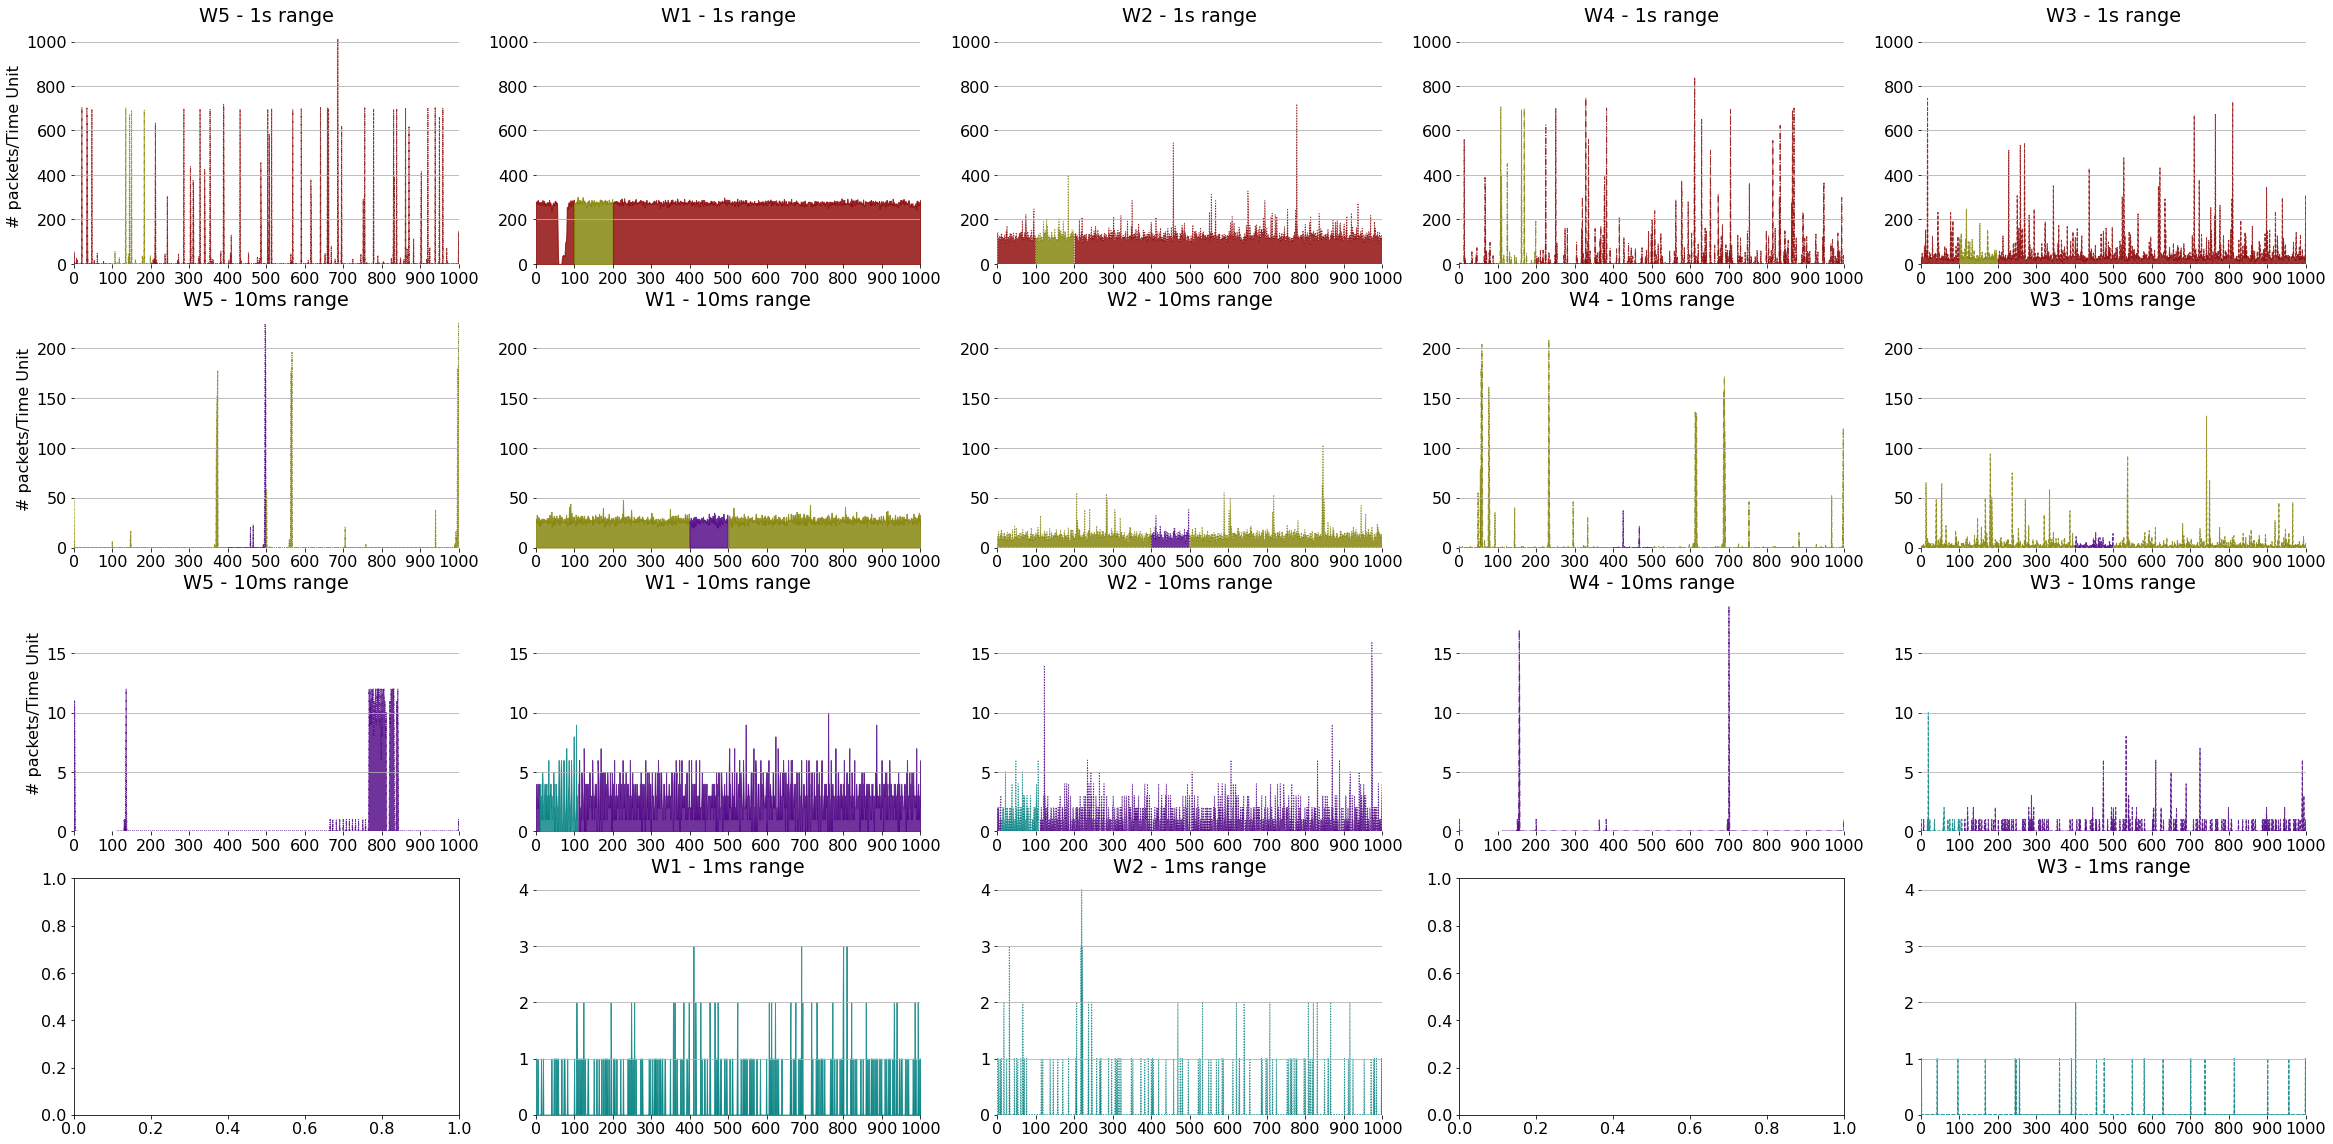

In [13]:
ims = []
scenario_names = []
row0_lims = (1000000000, 2000000000)
row1_lims = (1100000000, 1200000000)
row2_lims = (1140000000, 1150000000)
row3_lims = (1141000000, 1142000000)
range_lim = [1000000000, 100000000, 10000000, 1000000]
range_labels = ["1s", "10ms", "10ms", "1ms"]
range_ylims = [[],[],[],[]]
axes = [[],[],[],[]]
hurst = [[],[],[],[]]
ylims = [40000, 5000, 1000, 10]
colors = ['darkred', 'olive', 'indigo', 'teal']
fig, ax = plt.subplots(nrows= len(range_lim), ncols=len(size_timeseries), figsize=(8*len(size_timeseries),5*len(colors)), squeeze=False)
col = 0
for experiment, _ in size_timeseries.items():
    scenario_names.append(EXPERIMENT_MAP[experiment])
    ########
    sp = ax[0][col]
    times, sizes = zip(*size_timeseries[experiment])
    filtered_times = []
    start_time = times[0]
    for t in range(len(times)):
        if times[t] - start_time > row0_lims[0] and times[t] - start_time < row0_lims[1]:
            filtered_times.append(times[t] - start_time)
    # print(len(filtered_times))
    start_time = filtered_times[0]
    times2 = [time - start_time for time in filtered_times]
    # print(len(times2), times2[-1], times2[0])
    hist, bin_edges = np.histogram(times2, bins=1000) #, weights=sizes)
    split_bin1 = int((row1_lims[0]-row0_lims[0])*1000/range_lim[0])
    split_bin2 = split_bin1 + 100
    # print(split_bin1, split_bin2)
    # print(bin_edges)
    ims.append(sp.fill_between(bin_edges[:split_bin1], hist[:split_bin1], label=EXPERIMENT_MAP[experiment], color=colors[0],
                                                linestyle=linestyles[experiment], linewidth=1, alpha=0.8))
    ims.append(sp.fill_between(bin_edges[split_bin1:split_bin2], hist[split_bin1:split_bin2], label=EXPERIMENT_MAP[experiment], color=colors[1],
                                                    linestyle=linestyles[experiment], linewidth=1, alpha=0.8))
    ims.append(sp.fill_between(bin_edges[split_bin2+1:], hist[split_bin2:], label=EXPERIMENT_MAP[experiment], color=colors[0],
                                                linestyle=linestyles[experiment], linewidth=1, alpha=0.8))
    
    sp.grid(axis='y')
    # sp.legend()
    # sp.set_ylim(0, ylims[row])
    range_ylims[0].append(sp.get_ylim()[1])
    if len(times2) > 0:
        sp.set_xlim(0, times2[-1])
    sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[0]))
    sp.set_xticks(np.linspace(0,times2[-1],11), np.arange(0, 1100, 100))
    if col == 0:
        sp.set_ylabel(r'# packets/Time Unit')
    # sp.set_xlabel(r'Time bin (ns)')
    # sp.ticklabel_format(useOffset=False, style='plain')
    for spine in sp.spines.values():
        spine.set_visible(False)
    axes[0].append(sp)
    
    sp = ax[1][col]
    # times, sizes = zip(*size_timeseries[experiment])
    filtered_times = []
    start_time = times[0]
    for t in range(len(times)):
        if times[t] - start_time > row1_lims[0] and times[t] - start_time < row1_lims[1]:
            filtered_times.append(times[t] - start_time)
            # sizes.append(size_dat[t])
    start_time = filtered_times[0]
    times2 = [time - start_time for time in filtered_times]
    hist, bin_edges = np.histogram(times2, bins=1000) #, weights=sizes)
    split_bin1 = int((row2_lims[0]-row1_lims[0])*1000/range_lim[1])
    split_bin2 = split_bin1 + 100
    ims.append(sp.fill_between(bin_edges[:split_bin1], hist[:split_bin1], label=EXPERIMENT_MAP[experiment], color=colors[1],
                                                linestyle=linestyles[experiment], linewidth=1, alpha=0.8))
    ims.append(sp.fill_between(bin_edges[split_bin1:split_bin2], hist[split_bin1:split_bin2], label=EXPERIMENT_MAP[experiment], color=colors[2],
                                                    linestyle=linestyles[experiment], linewidth=1, alpha=0.8))
    ims.append(sp.fill_between(bin_edges[split_bin2+1:], hist[split_bin2:], label=EXPERIMENT_MAP[experiment], color=colors[1],
                                                linestyle=linestyles[experiment], linewidth=1, alpha=0.8))

    sp.grid(axis='y')
    # sp.legend()
    # sp.set_ylim(0, ylims[row])
    range_ylims[1].append(sp.get_ylim()[1])
    if len(times2) > 0:
        sp.set_xlim(0, times2[-1])
    sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[1]))
    sp.set_xticks(np.linspace(0,times2[-1],11), np.arange(0, 1100, 100))
    if col == 0:
        sp.set_ylabel(r'# packets/Time Unit')

    for spine in sp.spines.values():
        spine.set_visible(False)
    axes[1].append(sp)
    
    sp = ax[2][col]
    try:
        # times, sizes = zip(*size_timeseries[experiment])
        filtered_times = []
        start_time = times[0]
        for t in range(len(times)):
            if times[t] - start_time > row2_lims[0] and times[t] - start_time < row2_lims[1]:
                filtered_times.append(times[t] - start_time)
                # sizes.append(size_dat[t])
        # times = [time - start_time for time in times if  ]
        start_time = filtered_times[0]
        times2 = [time - start_time for time in filtered_times]
        hist, bin_edges = np.histogram(times2, bins=1000) #, weights=sizes)
        split_bin1 = int((row3_lims[0]-row2_lims[0])*1000/range_lim[1])
        split_bin2 = split_bin1 + 100
        ims.append(sp.fill_between(bin_edges[:split_bin1], hist[:split_bin1], label=EXPERIMENT_MAP[experiment], color=colors[2],
                                                    linestyle=linestyles[experiment], linewidth=1, alpha=0.8))
        ims.append(sp.fill_between(bin_edges[split_bin1:split_bin2], hist[split_bin1:split_bin2], label=EXPERIMENT_MAP[experiment], color=colors[3],
                                                        linestyle=linestyles[experiment], linewidth=1, alpha=0.8))
        ims.append(sp.fill_between(bin_edges[split_bin2+1:], hist[split_bin2:], label=EXPERIMENT_MAP[experiment], color=colors[2],
                                                    linestyle=linestyles[experiment], linewidth=1, alpha=0.8))

        sp.grid(axis='y')

        range_ylims[2].append(sp.get_ylim()[1])
        if len(times2) > 0:
            sp.set_xlim(0, times2[-1])
        sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[2]))
        sp.set_xticks(np.linspace(0,times2[-1],11), np.arange(0, 1100, 100))
        if col == 0:
            sp.set_ylabel(r'# packets/Time Unit')
        for spine in sp.spines.values():
            spine.set_visible(False)
        axes[2].append(sp)
    except IndexError:
        pass
    
    
    sp = ax[3][col]
    try:
        # times, sizes = zip(*size_timeseries[experiment])
        filtered_times = []
        start_time = times[0]
        for t in range(len(times)):
            if times[t] - start_time > row3_lims[0] and times[t] - start_time < row3_lims[1]:
                filtered_times.append(times[t] - start_time)
        start_time = filtered_times[0]
        times2 = [time - start_time for time in filtered_times]
        hist, bin_edges = np.histogram(times2, bins=1000) #, weights=sizes)
        # split_bin1 = int(row1_lims[0]*1000/range_lim[0])
        # split_bin2 = split_bin1 + 100
        ims.append(sp.fill_between(bin_edges[1:], hist, label=EXPERIMENT_MAP[experiment], color=colors[3],
                                                    linestyle=linestyles[experiment], linewidth=1, alpha=0.8))

        sp.grid(axis='y')

        range_ylims[3].append(sp.get_ylim()[1])
        if len(times2) > 0:
            sp.set_xlim(0, times2[-1])
            sp.set_xticks(np.linspace(0,times2[-1],11), np.arange(0, 1100, 100))
        sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[3]))
        if col == 0:
            sp.set_ylabel(r'# packets/Time Unit')

        for spine in sp.spines.values():
            spine.set_visible(False)
        axes[3].append(sp)
    except IndexError:
        pass
        
    col+=1
for row in range(len(axes)):
    for ax in axes[row]:
        ax.set_ylim(0, max(range_ylims[row]))
    




### Autocorelation analysis

W5
W1
W2
W4
W3


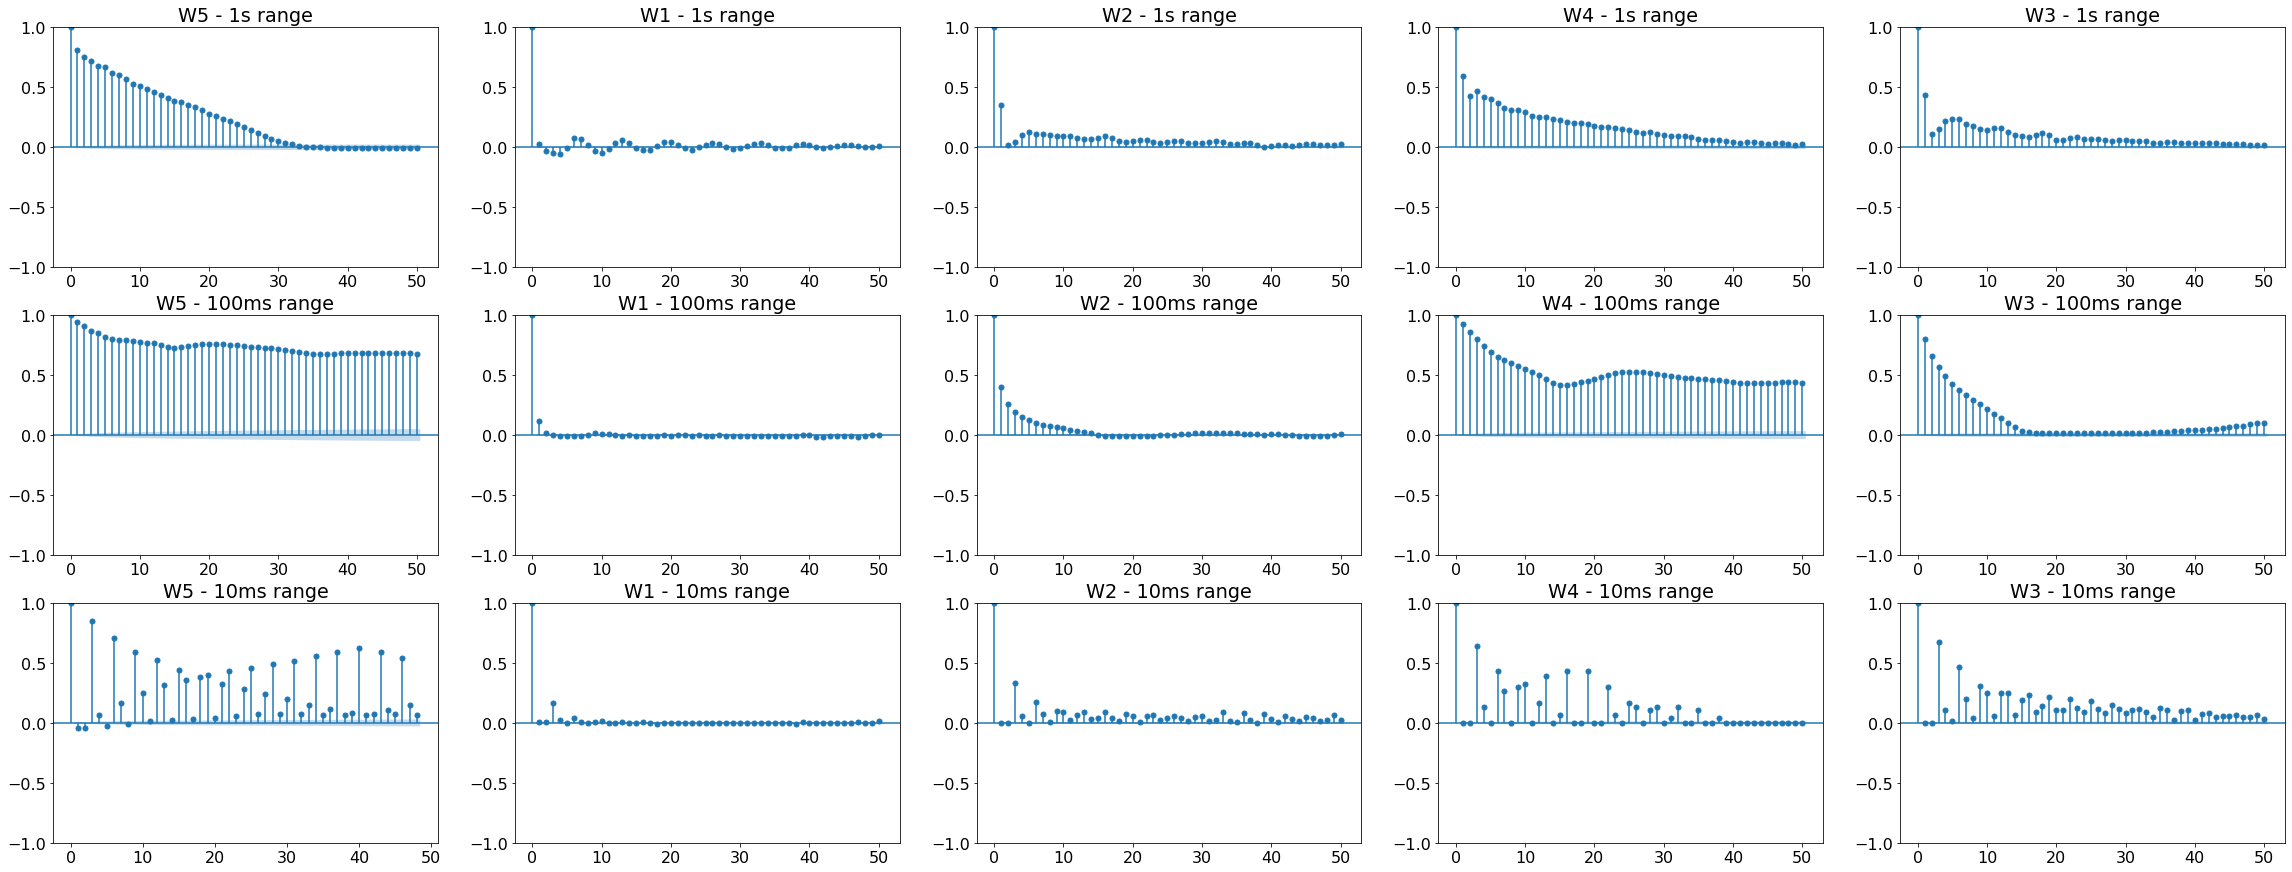

In [9]:
from statsmodels.graphics import tsaplots
import pandas as pd

########
ims = []
ranges = [(1000000000,2000000000),(900000000,1000000000),(990000000,1000000000)]
resample_bins = ["10000ns","1000ns","100ns"]
range_labels = ["1s", "100ms", "10ms"]

def calc_ts(st, resample_bin):
    data = pd.DataFrame(st, columns=['time', 'size'])
    data.set_index('time', inplace=True)
    data.index = pd.to_timedelta(data.index, unit='ns')
    duration = (data.index.seconds[-1] - data.index.seconds[0])
    diffs = data.index[1:] - data.index[:-1]
    res = data.resample(resample_bin).sum()
    # print(len(res), res)
    return np.array(res).ravel()

col = 0
scenario_names = []
fig, ax = plt.subplots(nrows= len(ranges), ncols=len(size_timeseries), figsize=(8*len(size_timeseries),5*len(ranges)), squeeze=False)

for experiment, ts in size_timeseries.items():
    scenario_names.append(EXPERIMENT_MAP[experiment])
    print(EXPERIMENT_MAP[experiment])
    times, sizes = zip(*ts)
    start_time = times[0]
    for r in range(len(ranges)):
        filtered_sizes = []
        filtered_times = []
        for t in range(1, len(times)):
            if  times[t] - start_time < ranges[r][0]:
                 continue
            if times[t] - start_time < ranges[r][1]:
                filtered_times.append(times[t] - start_time - ranges[r][0])
                filtered_sizes.append(sizes[t])
            else:
                break

        time_series = calc_ts(zip(filtered_times,filtered_sizes), resample_bins[r])
        # print(time_series,len(time_series))
        sp = ax[r][col]
        fig = tsaplots.plot_acf(time_series, ax=sp, alpha=.05)
        sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[r]))
    col += 1
    # break
###



### Partial Auto-correlation

W5


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


W1


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


W2


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


W4


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


W3


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


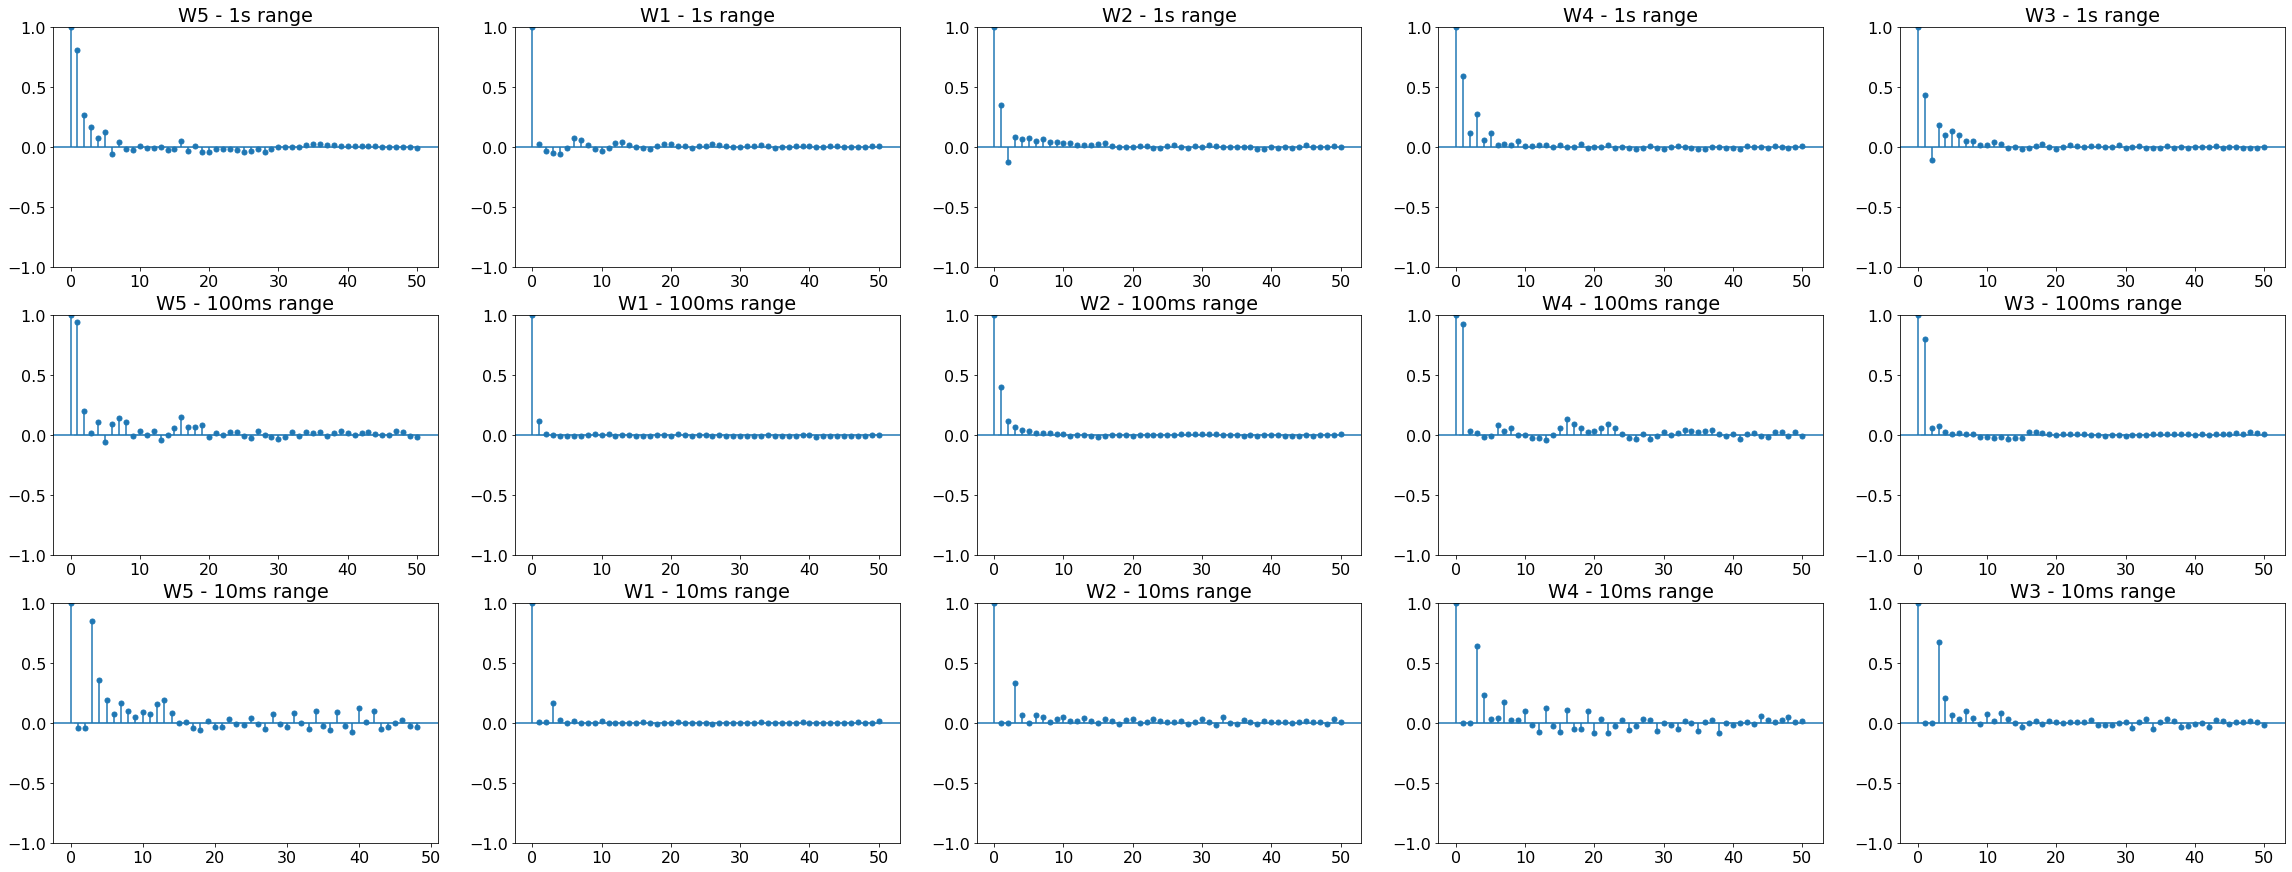

In [10]:
from statsmodels.graphics import tsaplots
import pandas as pd

########
ims = []
ranges = [(1000000000,2000000000),(900000000,1000000000),(990000000,1000000000)]
resample_bins = ["10000ns","1000ns","100ns"]
range_labels = ["1s", "100ms", "10ms"]

def calc_ts(st, resample_bin):
    data = pd.DataFrame(st, columns=['time', 'size'])
    data.set_index('time', inplace=True)
    data.index = pd.to_timedelta(data.index, unit='ns')
    duration = (data.index.seconds[-1] - data.index.seconds[0])
    diffs = data.index[1:] - data.index[:-1]
    res = data.resample(resample_bin).sum()
    # print(len(res), res)
    return np.array(res).ravel()

col = 0
scenario_names = []
fig, ax = plt.subplots(nrows= len(ranges), ncols=len(size_timeseries), figsize=(8*len(size_timeseries),5*len(ranges)), squeeze=False)

for experiment, ts in size_timeseries.items():
    scenario_names.append(EXPERIMENT_MAP[experiment])
    print(EXPERIMENT_MAP[experiment])
    times, sizes = zip(*ts)
    start_time = times[0]
    for r in range(len(ranges)):
        filtered_sizes = []
        filtered_times = []
        for t in range(1, len(times)):
            if  times[t] - start_time < ranges[r][0]:
                 continue
            if times[t] - start_time < ranges[r][1]:
                filtered_times.append(times[t] - start_time - ranges[r][0])
                filtered_sizes.append(sizes[t])
            else:
                break

        time_series = calc_ts(zip(filtered_times,filtered_sizes), resample_bins[r])
        # print(time_series,len(time_series))
        sp = ax[r][col]
        fig = tsaplots.plot_pacf(time_series, ax=sp, alpha=.05)
        sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[r]))
    col += 1
    # break
###



### Hurst analysis

In [11]:
import pandas as pd
import time
ims = []
scenario_names = []
row0_lims = (900000000,1000000000)
row1_lims = (1000000, 101000000)
row2_lims = (9200000, 19200000)
range_lim = [1000000000, 100000000, 10000000]
range_labels = ["1s", "100ms", "10ms"]
range_ylims = [[],[],[]]
axes = [[],[],[]]
hurst = {}

def pandas_hurst(st):
    data = pd.DataFrame(st, columns=['time', 'size'])
    data.set_index('time', inplace=True)
    data.index = pd.to_timedelta(data.index, unit='ns')
    duration = (data.index.seconds[-1] - data.index.seconds[0])
    diffs = data.index[1:] - data.index[:-1]
    res = data.resample('100ns').sum()
    H, c, data = compute_Hc(res, kind='change', simplified=False)
    print("Hurst exp=", H)
    return H


def pandas_hurst_interpolated(st):
    data = pd.DataFrame(st, columns=['time', 'size'])
    data.set_index('time', inplace=True)
    data.index = pd.to_timedelta(data.index, unit='ns')
    duration = (data.index.seconds[-1] - data.index.seconds[0])
    data = data.loc[~data.index.duplicated(), :]
    res = data.resample('100us').mean().interpolate()
    hist = res.iloc[:,0]
    H, c, data = compute_Hc(hist, kind='change', simplified=False)

    print(H)
    return H

col = 0
for lags in [1]:
    scenario_names = []
    for experiment, ts in size_timeseries.items():
        scenario_names.append(EXPERIMENT_MAP[experiment])
        times, sizes = zip(*ts)
        start_time = times[0]
        filtered_sizes = []
        filtered_times = []
        for t in range(1, len(times)):
            if  times[t] - start_time < row0_lims[0]:
                 continue
            if times[t] - start_time < row0_lims[1]:
                filtered_times.append(times[t] - start_time - row0_lims[0])
                filtered_sizes.append(sizes[t])
            else:
                break
        H = pandas_hurst(zip(filtered_times,filtered_sizes))
        print(EXPERIMENT_MAP[experiment], H)

W5
5200
resampled size =  848483
Hurst exp= 0.8863695361868232
CI= 0.19623486950897256
W5 0.8863695361868232
W1
27419
resampled size =  999972
Hurst exp= 0.5442640592258008
CI= 0.8673689267023691
W1 0.5442640592258008
W2
12714
resampled size =  999933
Hurst exp= 0.6504286685498721
CI= 0.5105884689434177
W2 0.6504286685498721
W4
4159
resampled size =  987295
Hurst exp= 0.8365369934718834
CI= 0.25070302654379684
W4 0.8365369934718834
W3
5042
resampled size =  998893
Hurst exp= 0.7503671450743489
CI= 0.34608719285807116
W3 0.7503671450743489


### Byte time-series

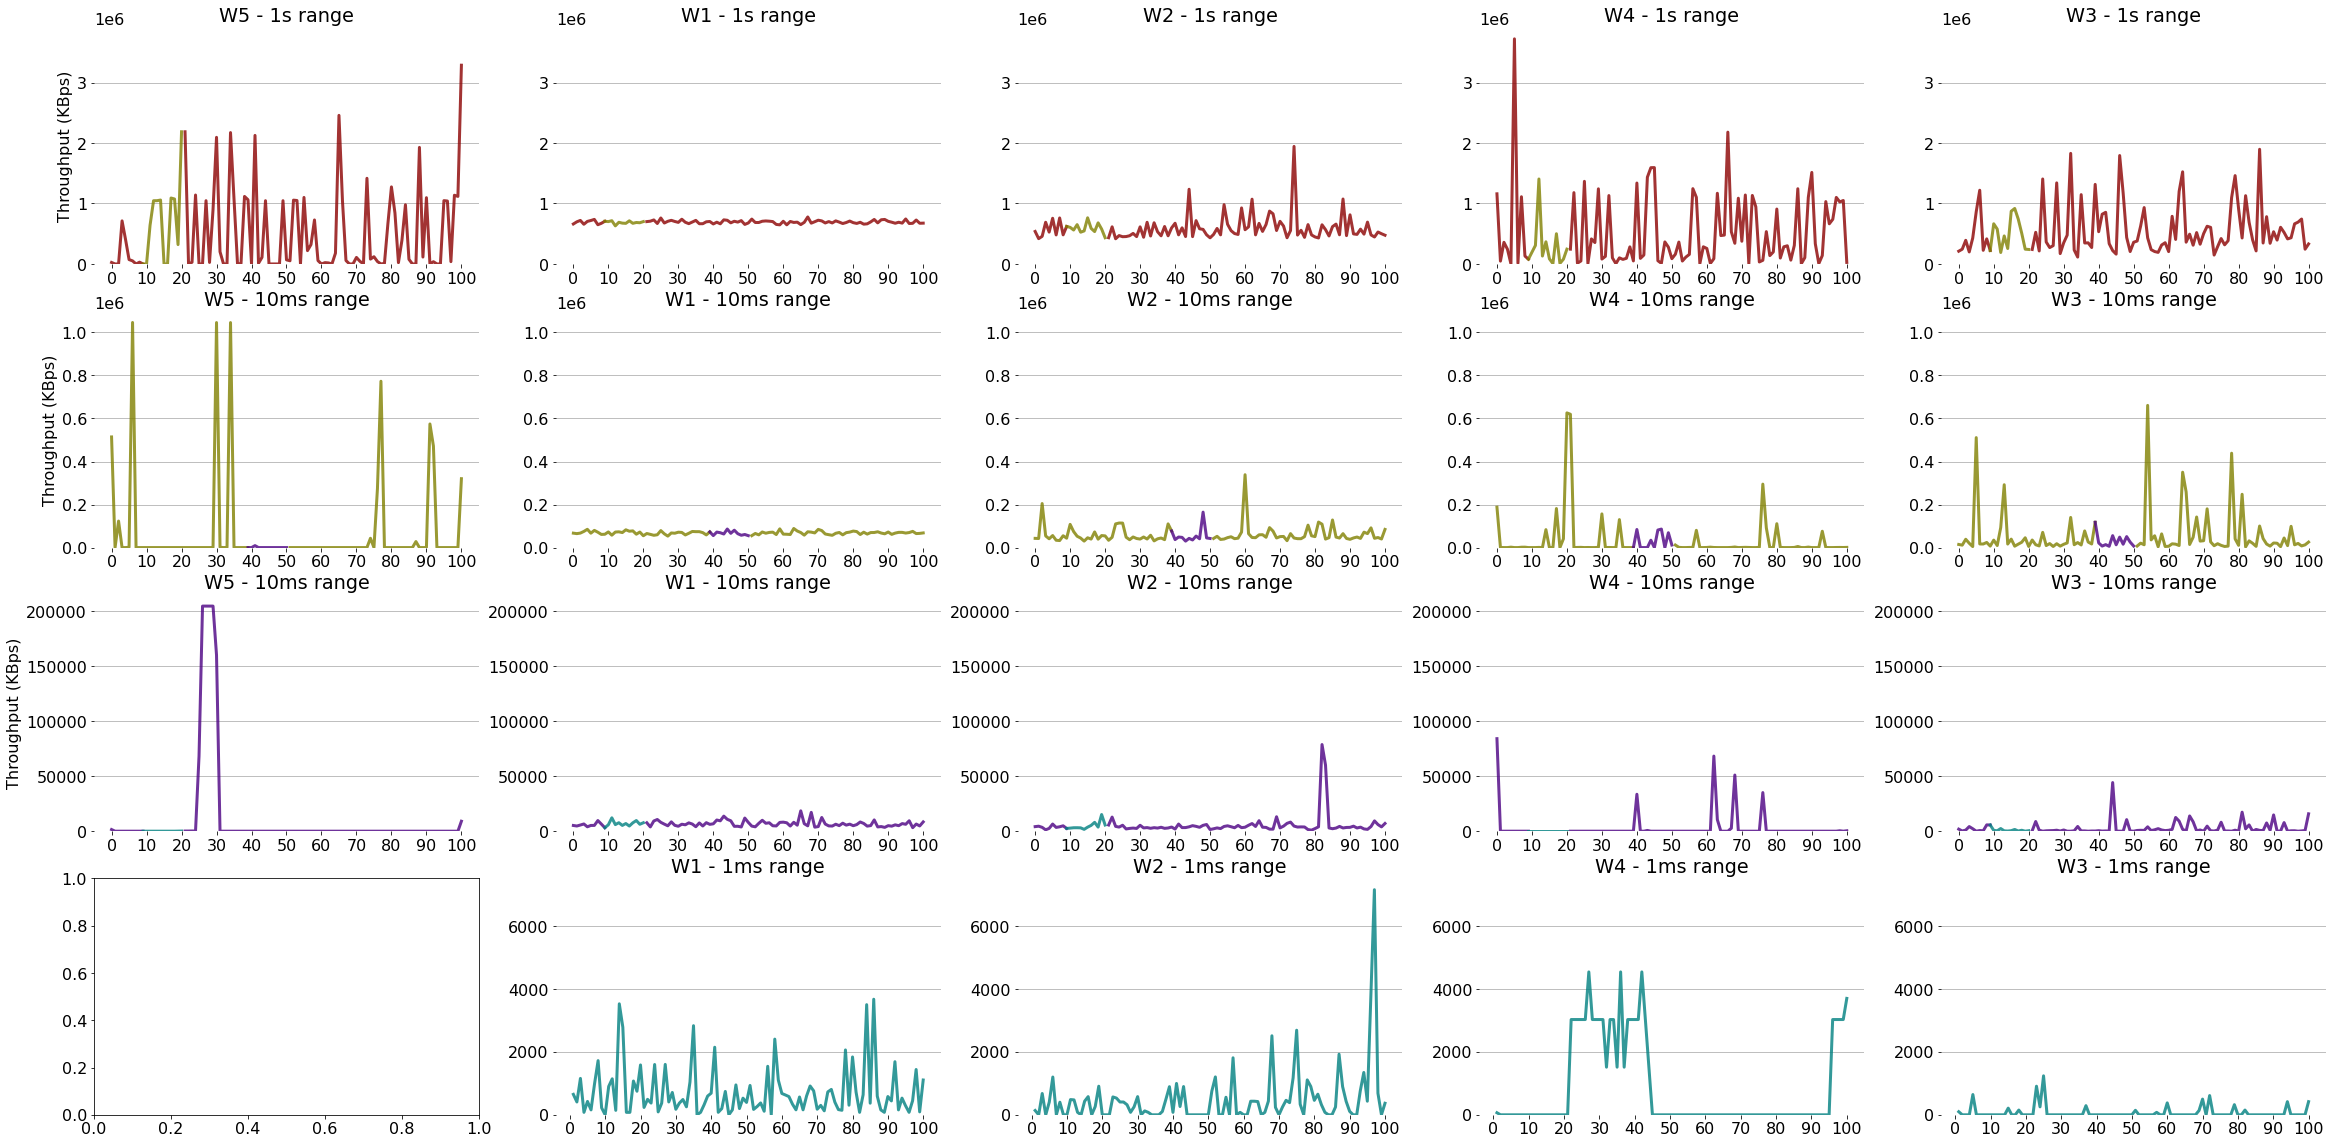

In [12]:
ims = []
scenario_names = []
row0_lims = (0, 1000000000)
row1_lims = (100000000, 200000000)
row2_lims = (140000000, 150000000)
row3_lims = (141000000, 142000000)
range_lim = [1000000000, 100000000, 10000000, 1000000]
range_labels = ["1s", "10ms", "10ms", "1ms"]
range_ylims = [[],[],[],[]]
axes = [[],[],[],[]]
hurst = [[],[],[],[]]
ylims = [40000, 5000, 1000, 10]
colors = ['darkred', 'olive', 'indigo', 'teal']
fig, ax = plt.subplots(nrows= len(range_lim), ncols=len(ts_data), figsize=(8*len(ts_data),5*len(colors)), squeeze=False)
col = 0
# for experiment, times in ts_data.items():
for experiment, _ in size_timeseries.items():
    # times = ts_data[experiment]
    times, size_dat = zip(*size_timeseries[experiment])
    scenario_names.append(EXPERIMENT_MAP[experiment])
    
    ########
    sp = ax[0][col]
    sizes = []
    filtered_times = []
    start_time = times[0]
    for t in range(len(times)):
        if times[t] - start_time > row0_lims[0] and times[t] - start_time < row0_lims[1]:
            filtered_times.append(times[t] - start_time)
            sizes.append(size_dat[t])
    start_time = times[0]
    times2 = [time - start_time for time in filtered_times]
    hist, bin_edges = np.histogram(times2, bins=100, weights=sizes) #, weights=sizes)
    # print(hist)
    # hist /= (range_lim[0]/1000000000)
    split_bin1 = int(row1_lims[0]*100/range_lim[0])
    split_bin2 = split_bin1 + 10
    ims.append(sp.plot(bin_edges[:split_bin1], hist[:split_bin1], label=EXPERIMENT_MAP[experiment], color=colors[0],
                                                linewidth=3, alpha=0.8))
    ims.append(sp.plot(bin_edges[split_bin1-1:split_bin2+1], hist[split_bin1-1:split_bin2+1], label=EXPERIMENT_MAP[experiment], color=colors[1],
                                                    linewidth=3, alpha=0.8))
    ims.append(sp.plot(bin_edges[split_bin2+1:], hist[split_bin2:], label=EXPERIMENT_MAP[experiment], color=colors[0],
                                                linewidth=3, alpha=0.8))
    

    sp.grid(axis='y')
    # sp.legend()
    # sp.set_ylim(0, ylims[row])
    range_ylims[0].append(sp.get_ylim()[1])
    # if len(times) > 0:
    #     sp.set_xlim(0, times[-1])
    sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[0]))
    sp.set_xticks(np.linspace(bin_edges[0],bin_edges[-1],11), np.arange(0, 110, 10))
    if col == 0:
        sp.set_ylabel(r'Throughput (KBps)')
    # sp.set_xlabel(r'Time bin (ns)')
    # sp.ticklabel_format(useOffset=False, style='plain')
    for spine in sp.spines.values():
        spine.set_visible(False)
    axes[0].append(sp)
    
    sp = ax[1][col]
    sizes = []
    filtered_times = []
    start_time = times[0]
    for t in range(len(times)):
        if times[t] - start_time > row1_lims[0] and times[t] - start_time < row1_lims[1]:
            filtered_times.append(times[t] - start_time)
            sizes.append(size_dat[t])
    # times = [time - start_time for time in times if  ]
    start_time = times[0]
    times2 = [time - start_time for time in filtered_times]
    hist, bin_edges = np.histogram(times2, bins=100, weights=sizes) #, weights=sizes)
    # hist /= (range_lim[1]/1000000000)
    split_bin1 = int((row2_lims[0]-row1_lims[0])*100/range_lim[1])
    split_bin2 = split_bin1 + 10
    ims.append(sp.plot(bin_edges[:split_bin1], hist[:split_bin1], label=EXPERIMENT_MAP[experiment], color=colors[1],
                                                linewidth=3, alpha=0.8))
    ims.append(sp.plot(bin_edges[split_bin1-1:split_bin2+1], hist[split_bin1-1:split_bin2+1], label=EXPERIMENT_MAP[experiment], color=colors[2],
                                                    linewidth=3, alpha=0.8))
    ims.append(sp.plot(bin_edges[split_bin2+1:], hist[split_bin2:], label=EXPERIMENT_MAP[experiment], color=colors[1],
                                                linewidth=3, alpha=0.8))
    sp.grid(axis='y')
    # sp.legend()
    # sp.set_ylim(0, ylims[row])
    range_ylims[1].append(sp.get_ylim()[1])
    # if len(times) > 0:
    #     sp.set_xlim(0, times[-1])
    sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[1]))
    sp.set_xticks(np.linspace(bin_edges[0],bin_edges[-1],11), np.arange(0, 110, 10))
    if col == 0:
        sp.set_ylabel(r'Throughput (KBps)')
    # sp.set_xlabel(r'Time bin (ns)')
    # sp.ticklabel_format(useOffset=False, style='plain')
    for spine in sp.spines.values():
        spine.set_visible(False)
    axes[1].append(sp)
    
    try:
        sp = ax[2][col]
        sizes = []
        filtered_times = []
        start_time = times[0]
        for t in range(len(times)):
            if times[t] - start_time > row2_lims[0] and times[t] - start_time < row2_lims[1]:
                filtered_times.append(times[t] - start_time)
                sizes.append(size_dat[t])
        # times = [time - start_time for time in times if  ]
        start_time = filtered_times[0]
        times2 = [time - start_time for time in filtered_times]
        hist, bin_edges = np.histogram(times2, bins=100, weights=sizes) #, weights=sizes)
        # hist /= (range_lim[2]/1000000000)
        split_bin1 = int((row3_lims[0] - row2_lims[0])*100/range_lim[2]) ##!!
        split_bin2 = split_bin1 + 10
        ims.append(sp.plot(bin_edges[:split_bin1], hist[:split_bin1], label=EXPERIMENT_MAP[experiment], color=colors[2],
                                                    linewidth=3, alpha=0.8))
        ims.append(sp.plot(bin_edges[split_bin1-1:split_bin2+1], hist[split_bin1-1:split_bin2+1], label=EXPERIMENT_MAP[experiment], color=colors[3],
                                                        linewidth=3, alpha=0.8))
        ims.append(sp.plot(bin_edges[split_bin2+1:], hist[split_bin2:], label=EXPERIMENT_MAP[experiment], color=colors[2],
                                                    linewidth=3, alpha=0.8))
        sp.grid(axis='y')
        # sp.legend()
        # sp.set_ylim(0, ylims[row])
        range_ylims[2].append(sp.get_ylim()[1])
        # if len(times) > 0:
        #     sp.set_xlim(0, times[-1])
        sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[2]))
        sp.set_xticks(np.linspace(bin_edges[0],bin_edges[-1],11), np.arange(0, 110, 10))
        if col == 0:
            sp.set_ylabel(r'Throughput (KBps)')
        for spine in sp.spines.values():
            spine.set_visible(False)
        axes[2].append(sp)
    except IndexError:
        pass
    
    try:
        sp = ax[3][col]
        sizes = []
        filtered_times = []
        start_time = times[0]
        for t in range(len(times)):
            if times[t] - start_time > row3_lims[0] and times[t] - start_time < row3_lims[1]:
                filtered_times.append(times[t] - start_time)
                sizes.append(size_dat[t])
        # times = [time - start_time for time in times if  ]
        start_time = filtered_times[0]
        times2 = [time - start_time for time in filtered_times]
        hist, bin_edges = np.histogram(times2, bins=100, weights=sizes) #, weights=sizes)
        # hist /= (range_lim[3]/10000000)
        ims.append(sp.plot(bin_edges[1:], hist, label=EXPERIMENT_MAP[experiment], color=colors[3],
                                                    linewidth=3, alpha=0.8))

        sp.grid(axis='y')
        # sp.legend()
        # sp.set_ylim(0, ylims[row])
        range_ylims[3].append(sp.get_ylim()[1])
        if len(times) > 0:
            # sp.set_xlim(0, times[-1])
            sp.set_xticks(np.linspace(bin_edges[0],bin_edges[-1],11), np.arange(0, 110, 10))
        sp.set_title("{} - {} range".format(EXPERIMENT_MAP[experiment], range_labels[3]))
        if col == 0:
            sp.set_ylabel(r'Throughput (KBps)')
        # sp.set_xlabel(r'Time bin (ns)')
        # sp.ticklabel_format(useOffset=False, style='plain')
        for spine in sp.spines.values():
            spine.set_visible(False)
        axes[3].append(sp)
    except IndexError:
        pass

        
    col+=1
for row in range(len(axes)):
    for ax in axes[row]:
        ax.set_ylim(0, max(range_ylims[row]))


### Measuring bursts in Bytes: Burst length heatmaps

In [ ]:
b_mins = []
b_maxes = []
heat_map = {}
cases = []
scenario_plot_data = {}
for experiment, _ in ts_data.items():
    heat_map[experiment] = []
ipg_in_order = []

for ipg, exp_b_lengths in cdf_map.items():
    for exp in range(len(exp_b_lengths)):
        try:
            b_mins.append(np.amin(exp_b_lengths[exp]))
            b_maxes.append(np.amax(exp_b_lengths[exp]))
        except ValueError:
            pass
    
b_min = np.min(b_mins)
b_max = np.max(b_maxes)
BINS = np.geomspace(b_min, b_max, 10)
BIN_LABELS = [int(i) for i in BINS]
for ipg, exp_b_lengths in cdf_map.items():
    ipg_in_order.append(ipg)
    for exp in range(len(exp_b_lengths)):
        # print(np.mean(exp_b_lengths[exp]), end=' ')
        processed_lengths, bin_ranges = np.histogram(exp_b_lengths[exp], bins=BINS)
        heat_map[exp_keys[exp]].append(processed_lengths)
x_labels = []
BIN_LABELS.insert(0, 0)
for i in range(1, len(BIN_LABELS)):
    x_labels.append("{}-{}".format(format(BIN_LABELS[i-1], ","), format(BIN_LABELS[i], ",")))
nrows = len(heat_map)//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(20,10*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(heat_map):
            ims.append(col.imshow(heat_map[exp_keys[case_index]], cmap='jet', interpolation='none',
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=np.amax(heat_map[exp_keys[case_index]]))
                                 ))
            col.yaxis.set_ticks(np.arange(len(ipg_in_order)))
            col.set_yticklabels(ipg_in_order)
            col.set_ylabel(r'IPG threshold ($\mu$s)')
            col.xaxis.set_ticks(np.arange(len(BINS)-1))
            col.set_xticklabels(x_labels[1:], rotation=90)
            col.set_xlabel(r'Burst length (B)')
            col.set_title(experiment_names_in_order[case_index])
            for spine in col.spines.values():
                spine.set_visible(False)
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            case_index+=1
        else:
            col.axis('off')

plt.show()

In [ ]:
compact_map = []
for case in heat_map.keys():
    compact_map.append(heat_map[case][1])
nrows = 1
fig, ax = plt.subplots(nrows= nrows, ncols=1, figsize=(20,10*nrows), squeeze=False)
ims = []
col = ax[0][0]
ims.append(col.imshow(compact_map, cmap='jet', interpolation='none',
                     norm=mpl.colors.LogNorm(vmin=1, vmax=np.amax(compact_map))
                     ))
col.yaxis.set_ticks(np.arange(len(experiment_names_in_order)))
col.set_yticklabels(experiment_names_in_order)
col.set_ylabel(r'Scenario')
col.xaxis.set_ticks(np.arange(len(BINS)-1))
col.set_xticklabels(x_labels[1:], rotation=90)
col.set_xlabel(r'Burst length (B)')
# col.set_title(experiment_names_in_order[case_index])
for spine in col.spines.values():
    spine.set_visible(False)
cbar = col.figure.colorbar(ims[0], ax=col)
cbar.set_label('# of bursts')
# cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
# cbar.ax.ticklabel_format(useOffset=False)

plt.show()

-----------------------------
Aggregate Info
--------------

We aggregate all flows from the server machines and redo the above analysis again.

### Analyzing aggregate minimum inter-packet gaps 

We extract the min IPG among all flows together egressing from server and calculate mean minIPG and various percentiles. We draw histogram and CDF plots of minIPGs.

In [ ]:
for experiment, ipg_agg_data_list in ipg_agg_data.items():
    print("Experiment {} : {}".format(experiment, EXPERIMENT_MAP[experiment]))
    print("Number of Aggregate IPG entries", len(ipg_agg_data_list))
    print("Minimum aggregate IPG: ", format(min(ipg_agg_data_list), ','), "ns")
    print("Maximum aggregate IPG: ", format(max(ipg_agg_data_list), ','), "ns")
    print("mean aggregate IPG: {} ns".format(np.mean(ipg_agg_data_list)))
    print("p10 aggregate IPG: {} ns".format(np.percentile(ipg_agg_data_list, 0.1)))
    print("p50 aggregate IPG: {} ns".format(np.percentile(ipg_agg_data_list, 0.5)))
    print("p90 aggregate IPG: {} ns".format(np.percentile(ipg_agg_data_list, 0.9)))
    print("p99 aggregate IPG: {} ns".format(np.percentile(ipg_agg_data_list, 0.99)))
    print("p999 aggregate IPG: {} ns".format(np.percentile(ipg_agg_data_list, 0.999)))
    print("--------------")

In [ ]:
plots = []
fig, ax1 = plt.subplots(figsize=(10,5))
for experiment, ipg_agg_data_list in ipg_agg_data.items():
    ecdf_f = ECDF(ipg_agg_data_list)
    cdf_x = np.linspace(min(ipg_agg_data_list), max(ipg_agg_data_list), 400000)
    cdf_y = ecdf_f(cdf_x)
    plots.append(ax1.plot(cdf_x, cdf_y, marker='o', markevery=0.1, markersize=10, linewidth=4, alpha=0.5, label=EXPERIMENT_MAP[experiment]))
ax1.set_ylabel("")
ax1.set_xlabel("IPG (ns)")
ax1.set_title("Aggregate IPG CDF")
ax1.grid(axis='y')
plt.legend()
plt.show()

### Counting the number of bursts

Using the xpyns definition, we use a brute force process to try various values for x and y and find best values according to load intensity.

Modify the below two lists to try different values:

BURST_DIFF_LIST: cut-off thresholds for each burst, in nanoseconds.

BURST_CONSEQUENT_LIST: minimum number of packets that need to have a IPG smaller than BURST_DIFF to be considered a burst.

In [ ]:
BURST_DIFF_LIST = [12, 24, 36, 48, 96, 128, 256, 512, 1024, 2048]
BURST_CONSEQUENT_LIST = [2, 4, 6, 8, 10, 12, 16]
##############################################
experiment_names_in_order_aggregate = []
print('xpyns |\t\t', end='')
for experiment, _ in ts_aggregate_data.items():
    experiment_names_in_order_aggregate.append(EXPERIMENT_MAP[experiment])
    print(EXPERIMENT_MAP[experiment], '\t', end='')
print()
heat_map_aggregate = []
for BURST_DIFF in BURST_DIFF_LIST:
    inner_list = []
    for BURST_CONSEQUENT in BURST_CONSEQUENT_LIST:
        inner_inner_list = []
        print('{}p{}ns |\t'.format(BURST_CONSEQUENT, BURST_DIFF), end='')
        for experiment, _ in ts_aggregate_data.items():
            bursty_x = {}
            bursty_y = {}
            bursty_legend = []
            b_counter = 0
            cdf_x = []
            cdf_y = []
            bar_x = []
            bar_y = []
            ts = ts_aggregate_data[experiment]
            key_bursty_x = []
            key_bursty_y = []
            no_of_bursts = 0
            for i in range(1, len(ts)):
                if ts[i] - ts[i-1] < BURST_DIFF:
                    b_counter+=1
                else:
                    if b_counter >= BURST_CONSEQUENT:
                        key_bursty_x.append(i)
                        key_bursty_y.append(b_counter)
                        no_of_bursts+=1
                        bar_x.append(ts[i-b_counter])
                        bar_y.append(b_counter)
                    # else:
                    #     print(ts[i] - ts[i-1])
                    b_counter = 0
            if no_of_bursts > 0:
                bursty_x[experiment] = key_bursty_x
                bursty_y[experiment] = key_bursty_y
                bursty_legend.append(experiment)
                print("{}\t".format(no_of_bursts), end='')
            else:
                print("0\t", end='')
            inner_inner_list.append(no_of_bursts)
        inner_list.append(inner_inner_list)
        print()
    heat_map_aggregate.append(inner_list)
normalized_heat_map_aggregate = heat_map_aggregate

### Single burst-parameter analysis

Use the best parameters (x,y) from above script to prepare a timeseries plot of bursts.

In [ ]:
BURST_DIFF = 512
BURST_CONSEQUENT = 16
experiment_bar_x = {}
experiment_bar_y = {}

for experiment, ts in ts_aggregate_norm_data.items():
    print("Experiment {} : {}".format(experiment, EXPERIMENT_MAP[experiment]))
    bursty_x = {}
    bursty_y = {}
    bursty_legend = []
    b_counter = 0
    cdf_x = []
    cdf_y = []
    bar_x = []
    bar_y = []
    key_bursty_x = []
    key_bursty_y = []
    no_of_bursts = 0
    for i in range(1, len(ts)):
        if ts[i] - ts[i-1] < BURST_DIFF:
            b_counter+=1
        else:
            if b_counter >= BURST_CONSEQUENT:
                key_bursty_x.append(i)
                key_bursty_y.append(b_counter)
                no_of_bursts+=1
                bar_x.append(ts[i-b_counter])
                bar_y.append(b_counter)
            # else:
            #     print(ts[i] - ts[i-1])
            b_counter = 0
    experiment_bar_x[experiment] = bar_x
    experiment_bar_y[experiment] = bar_y
    if no_of_bursts > 0:
        bursty_x[k] = key_bursty_x
        bursty_y[k] = key_bursty_y
        bursty_legend.append(k)
        print("{}p{}ns: {} total bursts".format(BURST_CONSEQUENT, BURST_DIFF, no_of_bursts))
    else:
        print("No bursts with setting {}p{}ns found".format(BURST_CONSEQUENT, BURST_DIFF))
    print()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))
plots = []
for experiment, bar_x in experiment_bar_x.items():
    plots.append(ax1.plot(bar_x, experiment_bar_y[experiment], marker='x', linewidth=0, alpha=0.8, linestyle=linestyles[experiment], label=EXPERIMENT_MAP[experiment]))
ax1.set_ylabel("# bursts")
ax1.set_xlabel("Time (ns)")
ax1.set_title("Timeseries of aggregate bursts for {}p{}ns".format(BURST_CONSEQUENT, BURST_DIFF))
ax1.grid(axis='y')
plt.legend()
plt.show()

### Heatmap data normalization

Execute below block to normalize all zeros into 0.1s in order to smoothen the log plots

In [ ]:
## normalizing heatmap data for log scale display
normalized_heat_map_aggregate = []
for i in range(len(heat_map_aggregate)):
    inner_list = []
    for j in range(len(heat_map_aggregate[i])):
        inner_inner_list = []
        for k in range(len(heat_map_aggregate[i][j])):
            if heat_map_aggregate[i][j][k] == 0:
                inner_inner_list.append(0.1)
            else:
                inner_inner_list.append(heat_map_aggregate[i][j][k])
                
        inner_list.append(inner_inner_list)
    normalized_heat_map_aggregate.append(inner_list)
print("Successfully normalized zero values in heatmap data")

### Configuration heatmaps: X/Y heatmap based on min burst length

In [ ]:
cases = []
case_names = [EXPERIMENT_MAP[i] for i, _ in ts_aggregate_data.items()]
if len(normalized_heat_map_aggregate[0][0]) > 0:
    for case in range(len(normalized_heat_map_aggregate[0][0])):
        case_list = []
        for i in normalized_heat_map_aggregate:
            inner_list = []
            for j in i:
                inner_list.append(j[0])
            case_list.append(inner_list)
        cases.append(case_list)

p_yticks = BURST_DIFF_LIST
p_xticks = BURST_CONSEQUENT_LIST
nrows = len(cases)//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(16,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(cases):
            ims.append(col.imshow(cases[case_index], cmap='jet', interpolation='none',
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=np.amax(heat_map_aggregate))))
            col.yaxis.set_ticks(np.arange(len(p_yticks)))
            col.set_yticklabels(p_yticks)
            col.set_ylabel(r'IPG threshold (ns)')
            col.xaxis.set_ticks(np.arange(len(BURST_CONSEQUENT_LIST)))
            col.set_xticklabels(p_xticks)
            col.set_xlabel(r'Min burst length (pkts)')
            col.set_title(case_names[case_index])
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Configuration heatmaps: XY/scenario heatmap based on min burst length

Columns in this heatmap can be used to quicly compare the burstiness of different scenarios

In [ ]:
cases = []
case_names = []
if len(normalized_heat_map_aggregate[0][0]) > 0:
    for row in range(len(normalized_heat_map_aggregate)):
        for col in range(len(normalized_heat_map_aggregate[row])):
            case_names.append((BURST_DIFF_LIST[row], BURST_CONSEQUENT_LIST[col]))
            cases.append(normalized_heat_map_aggregate[row][col])

p_xticks = experiment_names_in_order_aggregate
p_yticks = ['{}#{}'.format(i[0], i[1]) for i in case_names]

fig, col = plt.subplots(figsize=(20,20))
case_index = 0
ims = []

ims.append(col.imshow(cases, cmap='jet', interpolation='nearest', 
                     norm=mpl.colors.LogNorm(vmin=0.01, vmax=np.amax(heat_map_aggregate))))
col.xaxis.set_ticks(np.arange(len(p_xticks)))
col.set_xticklabels(p_xticks, rotation=90)
col.set_xlabel(r'Scenario')
col.yaxis.set_ticks(np.arange(len(p_yticks)))
col.set_yticklabels(p_yticks)
col.set_ylabel(r'Burst configuration (IPGThreshold#minBurstLength)')
col.set_title("")
col.set_xticks(np.arange(-.5, len(p_xticks) - 1, 1), minor=True)
col.set_yticks(np.arange(-.5, len(p_yticks) - 1, 1), minor=True)
col.grid(axis='x', which='minor', color='w', linestyle='-', linewidth=2)

cbar = col.figure.colorbar(ims[-1])
cbar.set_label('# of bursts')
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())

plt.show()

### Configuration heatmaps: X/Scenario heatmap based on min burst length

Each heatmap is drawn for one IPG threshold.

In [ ]:
BURST_DIFF_LIST = [12, 24, 36, 48, 96, 128, 256, 512, 1024, 2048]
BURST_CONSEQUENT_LIST = [2, 4, 6, 8, 10, 12, 16]
cases = []
case_names = []
for i in BURST_DIFF_LIST:
    case_names.append(i)
if len(normalized_heat_map_aggregate[0][0]) > 0:
    for case in range(len(normalized_heat_map_aggregate)):
        case_list = []
        for i in normalized_heat_map_aggregate[case]:
            inner_list = []
            for j in i:
                inner_list.append(j)
            case_list.append(inner_list)
        cases.append(case_list)

p_yticks = []
p_yticks = [EXPERIMENT_MAP[i] for i, _ in ts_aggregate_data.items()]
p_xticks = BURST_CONSEQUENT_LIST
nrows = len(cases)//2
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(25,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(cases):
            ims.append(col.imshow(np.transpose(cases[case_index]), cmap='jet', interpolation='nearest', 
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=np.amax(heat_map_aggregate))))
            col.xaxis.set_ticks(np.arange(len(BURST_CONSEQUENT_LIST)))
            col.set_xticklabels(p_xticks)
            col.set_xlabel(r'# packets')
            col.yaxis.set_ticks(np.arange(len(p_yticks)))
            col.set_yticklabels(p_yticks)
            col.set_ylabel(r'Scenario')
            col.set_title(case_names[case_index])
            col.set_xticks(np.arange(-.5, len(BURST_CONSEQUENT_LIST) - 1, 1), minor=True)
            col.set_yticks(np.arange(-.5, len(p_yticks) - 1, 1), minor=True)
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            col.grid(axis='y', which='minor', color='w', linestyle='-', linewidth=2)
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Timeseries of bursts based on user-defined X and Y values

Tracks the burstiness through time for all scenarios.


In [ ]:
######################################################
BURST_DIFF_LIST_TS = [256, 512, 1024]            #
BURST_CONSEQUENT_LIST_TS = [10, 12, 16]     #
BINS = 20
######################################################
subplots_total = len(BURST_DIFF_LIST_TS) * len(BURST_CONSEQUENT_LIST_TS)
plots_x = []
tseries_data = []
exp_order = []
for diff in BURST_DIFF_LIST_TS:
    for cons in BURST_CONSEQUENT_LIST_TS:
        experiment_ts_list = []
        for experiment, _ in ts_aggregate_data.items():
            ts_list = []
            b_counter = 0
            no_of_bursts = 0
            exp_order.append(experiment)
            ts = ts_aggregate_data[experiment]
            for i in range(1, len(ts_aggregate_data[experiment])):
                if ts[i] - ts[i-1] < diff:
                    b_counter+=1
                else:
                    if b_counter >= cons:
                        no_of_bursts+=1
                        ts_list.append(ts[i-b_counter])
                    b_counter = 0
            experiment_ts_list.append(ts_list)
        plots_x.append((diff, cons))
        tseries_data.append(experiment_ts_list)
# post-process ts data
plots_y = []
for config in range(len(tseries_data)):
    config_exps = []
    for exp in range(len(tseries_data[config])):
        processed_tseries = np.histogram(tseries_data[config][exp], bins=BINS)
        config_exps.append(processed_tseries[0])
    plots_y.append(config_exps)
        
fig, ax = plt.subplots(nrows= subplots_total//2 + 1, ncols=2, figsize=(16,8*(subplots_total//2 + 1)), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(plots_y):
            config_ims = []
            for exp in range(len(plots_y[case_index])):
                # print(len(exp[1]))
                experiment = exp_order[exp]
                ims.append(col.plot(np.arange(BINS), plots_y[case_index][exp],
                                    label=EXPERIMENT_MAP[exp_order[exp]],
                                    marker=markers[experiment], markevery=0.1, markersize=10, linestyle=linestyles[experiment],
                                    linewidth=4, alpha=0.8))
            ims.append(config_ims)
            col.set_xlabel(r'Time (t)')
            col.set_ylabel(r'# Bursts')
            col.set_title('{}#{}'.format(plots_x[case_index][0], plots_x[case_index][1]))
            col.legend()
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')
# plt.legend()
plt.show()

### Bar chart of burst lengths for all scenarios

Each plot belongs to one IPG threshold.

Modify `SELECTED_LENGTHS` list to displays bursts of arbitrary lengths.

In [ ]:
######################################################
BURST_DIFF_LIST = [256, 512, 1024]        # 128, 256, 512, 1024, 2048
SELECTED_LENGTHS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] 
######################################################
experiment_names_in_order_aggregate = []
histogram = {}
for BURST_DIFF in BURST_DIFF_LIST:
    inner_list = []
    experiment_names_in_order_aggregate = []
    histogram[BURST_DIFF] = {}
    for experiment, _ in ts_aggregate_data.items():
        experiment_names_in_order_aggregate.append(EXPERIMENT_MAP[experiment])
        no_of_bursts = 0
        b_counter = 0
        histogram[BURST_DIFF][experiment] = {}
        ts = ts_aggregate_data[experiment]
        for i in range(1, len(ts_aggregate_data[experiment])):
            if ts[i] - ts[i-1] < BURST_DIFF:
                b_counter+=1
            else:
                if b_counter >= 2:
                    if b_counter in histogram[BURST_DIFF][experiment]:
                        histogram[BURST_DIFF][experiment][b_counter] += 1
                    else:
                        histogram[BURST_DIFF][experiment][b_counter] = 1
                b_counter = 0
                    
plot_data = {}
for k, v in histogram.items():
    plot_data[k] = []
    exp_idx = 0
    for experiment, exp_map in v.items():
        plot_data[k].append([])
        for i in SELECTED_LENGTHS:
            if i in exp_map:
                plot_data[k][exp_idx].append(exp_map[i])
            else:
                plot_data[k][exp_idx].append(0)
        exp_idx += 1
            

X = np.arange(len(SELECTED_LENGTHS))
p_yticks = []
p_yticks = [EXPERIMENT_MAP[i] for i, _ in ts_aggregate_data.items()]
p_xticks = BURST_CONSEQUENT_LIST
number_of_cases = len(BURST_DIFF_LIST)
fig, ax = plt.subplots(nrows= number_of_cases, ncols=1, figsize=(16,8*number_of_cases), squeeze=False)
case_index = 0
STEP = 0.15
ims = []
for row in ax:
    for col in row:
        if case_index < number_of_cases:
            ims.append([])
            labels = []
            position = -((len(plot_data[BURST_DIFF_LIST[case_index]])//2) * STEP)
            for item in range(len(plot_data[BURST_DIFF_LIST[case_index]])):
                ims[case_index].append(col.bar(X + position, plot_data[BURST_DIFF_LIST[case_index]][item],
                                               width=0.15, label=experiment_names_in_order_aggregate[item]))
                position += STEP
                labels.append(experiment_names_in_order_aggregate[item])
            col.set_yscale('log')
            col.yaxis.set_major_formatter(ScalarFormatter())
            col.xaxis.set_ticks(np.arange(len(SELECTED_LENGTHS)))
            col.set_xticklabels(SELECTED_LENGTHS)
            col.set_xlabel(r'Burst length (pkts)')
            col.set_ylabel(r'# Bursts')
            col.set_title('{}'.format(BURST_DIFF_LIST[case_index]))
            col.legend(ims[case_index], labels)
            col.grid(axis='y', which='both', linestyle='-', linewidth=2)
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Heatmap of burst lengths grouped by IPG thresholds.

In [ ]:
fig, ax = plt.subplots(nrows= len(BURST_DIFF_LIST), ncols=1, figsize=(16,8*len(BURST_DIFF_LIST)), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            ims.append(col.imshow(plot_data[BURST_DIFF_LIST[case_index]], cmap='jet', interpolation='nearest', 
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=max(1, np.amax(plot_data[BURST_DIFF_LIST[case_index]])))))
            col.xaxis.set_ticks(np.arange(len(SELECTED_LENGTHS)))
            col.set_xticklabels(SELECTED_LENGTHS)
            col.set_xlabel(r'Min burst length (pkts)')
            col.yaxis.set_ticks(np.arange(len(experiment_names_in_order_aggregate)))
            col.set_yticklabels(experiment_names_in_order_aggregate)
            col.set_ylabel(r'Scenario')
            col.set_title(BURST_DIFF_LIST[case_index])
            col.set_xticks(np.arange(-.5, len(SELECTED_LENGTHS) - 1, 1), minor=True)
            col.set_yticks(np.arange(-.5, len(experiment_names_in_order_aggregate) - 1, 1), minor=True)
            col.grid(axis='y', which='minor', color='w', linestyle='-', linewidth=2)
            for spine in col.spines.values():
                spine.set_visible(False)
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            case_index+=1
        else:
            col.axis('off')

# ax1.set_ylabel("y")
# ax1.set_xlabel("x")
# ax1.set_title("Heatmap of per-flow configurations")
# plt.legend()
plt.show()

### Stacked bar chart of burst lengths

In [ ]:
number_of_cases = len(BURST_DIFF_LIST)
nrows = number_of_cases//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(24,16*nrows), squeeze=False)
case_index = 0
STEP = 0.75
ims = []
stacked_colors = mpl.cm.bwr(np.linspace(0, 1, len(SELECTED_LENGTHS)))
for row in ax:
    for col in row:
        if case_index < number_of_cases:
            y_offset = np.zeros(len(experiment_names_in_order_aggregate))
            X = np.arange(len(experiment_names_in_order_aggregate))
            labels = []
            for item in range(len(SELECTED_LENGTHS)):
                data = np.transpose(plot_data[BURST_DIFF_LIST[case_index]])
                ims.append(col.bar(X, data[item], width=STEP, label=SELECTED_LENGTHS[item],
                                               bottom=y_offset, color=stacked_colors[item]))
                y_offset = y_offset + data[item]
            col.set_yscale('log')
            col.yaxis.set_major_formatter(ScalarFormatter())
            col.xaxis.set_ticks(np.arange(len(experiment_names_in_order_aggregate)))
            col.set_xticklabels(experiment_names_in_order_aggregate, rotation=45)
            col.set_xlabel(r'Scenario')
            col.set_ylabel(r'# Bursts')
            col.set_title('{}'.format(BURST_DIFF_LIST[case_index]))
            col.legend(SELECTED_LENGTHS)
            handles, labels = col.get_legend_handles_labels()
            col.legend(reversed(handles), reversed(labels))
            col.grid(axis='y', which='both', linestyle='-', linewidth=2)
            col.set_facecolor('k')
            col.set_ylim(10**int(np.log10(col.get_ylim()[0])), col.get_ylim()[1])
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Heatmap of burst lengths grouped by scenarios


In [ ]:
cases = []
scenario_plot_data = {}
for ipg, ipg_val in histogram.items():
    for exp, exp_map in ipg_val.items():
        if exp not in scenario_plot_data:
            cases.append(exp)
            scenario_plot_data[exp] = [[] for i in range(len(BURST_DIFF_LIST))]
            
for ipg in range(len(BURST_DIFF_LIST)):
    for l in range(len(SELECTED_LENGTHS)):
        ipg_val = histogram[BURST_DIFF_LIST[ipg]]
        exp_idx = 0
        for exp, exp_map in ipg_val.items():
            if SELECTED_LENGTHS[l] in exp_map:
                scenario_plot_data[exp][ipg].append(exp_map[SELECTED_LENGTHS[l]])
            else:
                scenario_plot_data[exp][ipg].append(0)
            exp_idx+=1  

b_maxes = []
for exp_b_lengths in heat_map_aggregate:
    for exp in range(len(exp_b_lengths)):
        try:
            b_maxes.append(np.amax(exp_b_lengths[exp]))
        except ValueError:
            pass
    
max_val = np.max(b_maxes)

nrows = len(cases)//2 + 1
fig, ax = plt.subplots(nrows= len(cases)//2 + 1, ncols=2, figsize=(20,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(cases):
            ims.append(col.imshow(scenario_plot_data[cases[case_index]], cmap='jet', interpolation='none',
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=max_val)))
            col.yaxis.set_ticks(np.arange(len(BURST_DIFF_LIST)))
            col.set_yticklabels(BURST_DIFF_LIST)
            col.set_ylabel(r'IPG threshold (ns)')
            col.xaxis.set_ticks(np.arange(len(SELECTED_LENGTHS)))
            col.set_xticklabels(SELECTED_LENGTHS)
            col.set_xlabel(r'Burst length (pkts)')
            col.set_title(experiment_names_in_order_aggregate[case_index])
            for spine in col.spines.values():
                spine.set_visible(False)
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            case_index+=1
        else:
            col.axis('off')

plt.show()

### Measuring bursts in bytes: Burst length CDFs

In [ ]:
ts_sizes = get_aggregate_ts_sizes_all_keys(entries)
experiment_names_in_order_aggregate = []
exp_keys = []
for experiment, _ in ts_aggregate_data.items():
    experiment_names_in_order_aggregate.append(EXPERIMENT_MAP[experiment])
    exp_keys.append(experiment)

cdf_map = {}
for BURST_DIFF in BURST_DIFF_LIST:
    inner_list = []
    for experiment, _ in ts_aggregate_data.items():
        experiment_burst_lengths = []
        b_counter = 0
        no_of_bursts = 0
        burst_size = 0
        ts = ts_aggregate_data[experiment]
        burst_first_packet_size = ts_sizes[experiment][0]
        for i in range(1, len(ts)):
            if ts[i] - ts[i-1] < BURST_DIFF:
                b_counter+=1
                burst_size += ts_sizes[experiment][i]
            else:
                if b_counter >= 1:
                    no_of_bursts+=1
                    burst_size += burst_first_packet_size
                    experiment_burst_lengths.append(burst_size)
                burst_first_packet_size = ts_sizes[experiment][i]
                burst_size = 0
                b_counter = 0
        inner_list.append(experiment_burst_lengths)
    cdf_map[BURST_DIFF] = inner_list
    
nrows = len(BURST_DIFF_LIST)//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(20,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            ims.append([])
            for exp in range(len(cdf_map[BURST_DIFF_LIST[case_index]])):
                burst_lengths = cdf_map[BURST_DIFF_LIST[case_index]][exp]
                if len(burst_lengths) == 0:
                    continue
                ecdf_f = ECDF(burst_lengths)
                cdf_x = np.linspace(min(burst_lengths), max(burst_lengths), 400000)
                cdf_y = ecdf_f(cdf_x)
                experiment = exp_keys[exp]
                ims[case_index].append(col.plot(cdf_x, cdf_y, label=EXPERIMENT_MAP[experiment],
                                                marker=markers[experiment], markevery=0.1, markersize=10,
                                                linestyle=linestyles[experiment], linewidth=4, alpha=0.8))
            col.set_ylabel(r'CDF')
            col.set_xlabel(r'Burst length (B)')
            col.set_title(BURST_DIFF_LIST[case_index])
            col.grid(axis='y')
            if len(ims[case_index]) > 0:
                col.legend()
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()


### Measuring bursts in bytes: Burst length heatmaps

In [ ]:
b_mins = []
b_maxes = []
bl_heat_map_aggregate = {}
cases = []
scenario_plot_data = {}
for experiment, _ in ts_aggregate_data.items():
    bl_heat_map_aggregate[experiment] = []
ipg_in_order = []

for ipg, exp_b_lengths in cdf_map.items():
    for exp in range(len(exp_b_lengths)):
        try:
            b_mins.append(np.min(exp_b_lengths[exp]))
            b_maxes.append(np.max(exp_b_lengths[exp]))
        except ValueError:
            pass

b_min = np.min(b_mins)
b_max = np.max(b_maxes)
BINS = np.geomspace(b_min, b_max, 10)
BIN_LABELS = [int(i) for i in BINS]
x_labels = []
BIN_LABELS.insert(0, 0)
for i in range(1, len(BIN_LABELS)):
    x_labels.append("{}-{}".format(format(BIN_LABELS[i-1], ","), format(BIN_LABELS[i], ",")))
for ipg, exp_b_lengths in cdf_map.items():
    ipg_in_order.append(ipg)
    for exp in range(len(exp_b_lengths)):
        # print(np.mean(exp_b_lengths[exp]), end=' ')
        processed_lengths, bin_ranges = np.histogram(exp_b_lengths[exp], bins=BINS)
        bl_heat_map_aggregate[exp_keys[exp]].append(processed_lengths)

nrows = len(bl_heat_map_aggregate)//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(20,10*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(bl_heat_map_aggregate):
            ims.append(col.imshow(bl_heat_map_aggregate[exp_keys[case_index]], cmap='jet', interpolation='none',
                                 norm=mpl.colors.LogNorm(vmin=1, vmax=np.amax(bl_heat_map_aggregate[exp_keys[case_index]]))
                                 ))
            col.yaxis.set_ticks(np.arange(len(ipg_in_order)))
            col.set_yticklabels(ipg_in_order)
            col.set_ylabel(r'IPG threshold ($\mu$s)')
            col.xaxis.set_ticks(np.arange(len(BINS)))
            col.set_xticklabels(x_labels, rotation=90)
            col.set_xlabel(r'Burst length (B)')
            col.set_title(experiment_names_in_order_aggregate[case_index])
            for spine in col.spines.values():
                spine.set_visible(False)
            cbar = col.figure.colorbar(ims[case_index], ax=col)
            cbar.set_label('# of bursts')
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
            case_index+=1
        else:
            col.axis('off')

plt.show()

In [ ]:
print(bl_heat_map_aggregate)

### Measuring bursts in bytes: Burst length Probability density (histogram)

In [ ]:
nrows = len(BURST_DIFF_LIST)//2 + 1
fig, ax = plt.subplots(nrows= nrows, ncols=2, figsize=(20,8*nrows), squeeze=False)
case_index = 0
ims = []
for row in ax:
    for col in row:
        if case_index < len(BURST_DIFF_LIST):
            ims.append([])
            for exp in range(len(cdf_map[BURST_DIFF_LIST[case_index]])):
                burst_lengths = cdf_map[BURST_DIFF_LIST[case_index]][exp]
                if len(burst_lengths) == 0:
                    continue
                experiment = exp_keys[exp]
                ims[case_index].append(col.hist(burst_lengths, bins=50, label=EXPERIMENT_MAP[experiment],
                                                linestyle=linestyles[experiment], 
                                                linewidth=4, alpha=0.8, histtype=u'step'))
            col.set_ylabel(r'# Count')
            col.set_xlabel(r'Burst length (B)')
            col.set_title(BURST_DIFF_LIST[case_index])
            col.grid(axis='y')
            if len(ims[case_index]) > 0:
                col.legend()
            for spine in col.spines.values():
                spine.set_visible(False)
            case_index+=1
        else:
            col.axis('off')

plt.show()